### 필요 라이브러리 로드

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize']=14
matplotlib.rcParams['xtick.labelsize']=12
matplotlib.rcParams['ytick.labelsize']=12
matplotlib.rcParams['text.color']='k'

In [2]:
pd.set_option('display.max_columns',500) 
#출력시 생략 X

### 데이터셋 설정 

In [3]:
df=pd.read_excel("BG_sample18.xlsx")

In [4]:
df.shape

(1474, 14)

In [5]:
df.head(13)

색인 타임스탬프(YYYY-MM-DDThh:mm:ss) 이벤트 유형 이벤트 하위 유형                환자 정보  \
0    1                        NaN     이름       NaN                  sch   
1    2                        NaN      성       NaN                    3   
2    3                        NaN   생년월일       NaN  1983-01-24 00:00:00   
3    4                        NaN     장치       NaN                  NaN   
4    5                        NaN     경고        하락                  NaN   
5    6                        NaN     경고        높음                  NaN   
6    7                        NaN     경고        낮음                  NaN   
7    8                        NaN     경고     신호 손실                  NaN   
8    9                        NaN     경고        상승                  NaN   
9   10                        NaN     경고   긴급하게 낮음                  NaN   
10  11        2020-03-13T11:05:03     교정       NaN                  NaN   
11  12        2020-03-13T11:14:06     교정       NaN                  NaN   
12  13        2020-03-13T11:15:55    EGV       NaN                  NaN   

                   장치 정보 소스 장치 ID 포도당 값 (mg/dL)  인슐린 값(u)  탄수화물 값 (그램)  \
0                    NaN      NaN           NaN       NaN          NaN   
1                    NaN      NaN           NaN       NaN          NaN   
2                    NaN      NaN           NaN       NaN          NaN   
3   Dexcom G5 Mobile App  Android           NaN       NaN          NaN   
4                    NaN  Android           NaN       NaN          NaN   
5                    NaN  Android           250       NaN          NaN   
6                    NaN  Android            70       NaN          NaN   
7                    NaN  Android           NaN       NaN          NaN   
8                    NaN  Android           NaN       NaN          NaN   
9                    NaN  Android            55       NaN          NaN   
10                   NaN  Android           216       NaN          NaN   
11                   NaN  Android           244       NaN          NaN   
12                   NaN  Android           227       NaN          NaN   

   기간(hh:mm:ss)  포도당 변화율 (mg/dL/min)  트랜스미터 시간 (배장 정수) 트랜스미터 ID  
0           NaN                  NaN               NaN      NaN  
1           NaN                  NaN               NaN      NaN  
2           NaN                  NaN               NaN      NaN  
3           NaN                  NaN               NaN      NaN  
4           NaN                  3.0               NaN      NaN  
5           NaN                  NaN               NaN      NaN  
6           NaN                  NaN               NaN      NaN  
7      00:30:00                  NaN               NaN      NaN  
8           NaN                  3.0               NaN      NaN  
9           NaN                  NaN               NaN      NaN  
10          NaN                  NaN               NaN   42E570  
11          NaN                  NaN               NaN   42E570  
12          NaN                  NaN         6134328.0   42E570

In [6]:
#필요없는 열 제거
cols = ['색인', '이벤트 하위 유형', '환자 정보', '장치 정보', '소스 장치 ID', '기간(hh:mm:ss)', '포도당 변화율 (mg/dL/min)', '트랜스미터 시간 (배장 정수)', '트랜스미터 ID']
df.drop(cols, axis=1, inplace=True)


In [7]:
df=df.rename({'타임스탬프(YYYY-MM-DDThh:mm:ss)':'Timestamp','포도당 값 (mg/dL)':'Glucose','이벤트 유형':'Event',
             '인슐린 값(u)':'Insulin','탄수화물 값 (그램)':'Meal'},axis='columns')

In [8]:
df['Event'].value_counts()

EGV     1422
인슐린       21
탄수화물      17
경고         6
교정         4
성          1
이름         1
생년월일       1
장치         1
Name: Event, dtype: int64

In [9]:
df['Glucose'].value_counts()

높음     169
199     27
187     20
185     19
203     18
      ... 
284      1
279      1
272      1
399      1
55       1
Name: Glucose, Length: 242, dtype: int64

In [10]:
df.tail()

Timestamp Event Glucose  Insulin  Meal
1469  2020-03-18T09:20:43   EGV      높음      NaN   NaN
1470  2020-03-18T09:25:44   EGV      높음      NaN   NaN
1471  2020-03-18T09:30:43   EGV      높음      NaN   NaN
1472  2020-03-18T09:35:44   EGV      높음      NaN   NaN
1473  2020-03-18T09:40:44   EGV      높음      NaN   NaN

In [11]:
# 인슐린 투여횟수
df['Insulin'].value_counts()

0.0    21
Name: Insulin, dtype: int64

In [12]:
# 식사 횟수
df['Meal'].value_counts()

0.0    17
Name: Meal, dtype: int64

In [13]:
df.head(15)

Timestamp Event Glucose  Insulin  Meal
0                   NaN    이름     NaN      NaN   NaN
1                   NaN     성     NaN      NaN   NaN
2                   NaN  생년월일     NaN      NaN   NaN
3                   NaN    장치     NaN      NaN   NaN
4                   NaN    경고     NaN      NaN   NaN
5                   NaN    경고     250      NaN   NaN
6                   NaN    경고      70      NaN   NaN
7                   NaN    경고     NaN      NaN   NaN
8                   NaN    경고     NaN      NaN   NaN
9                   NaN    경고      55      NaN   NaN
10  2020-03-13T11:05:03    교정     216      NaN   NaN
11  2020-03-13T11:14:06    교정     244      NaN   NaN
12  2020-03-13T11:15:55   EGV     227      NaN   NaN
13  2020-03-13T11:20:50   EGV     227      NaN   NaN
14  2020-03-13T11:25:49   EGV     224      NaN   NaN

In [14]:
# Timestamp != NaN일 때까지 count하고 
# Nan에 해당하는 인스턴스 제거 
df=df.dropna(subset=['Timestamp'])

In [15]:
df.head(20)

Timestamp Event Glucose  Insulin  Meal
10  2020-03-13T11:05:03    교정     216      NaN   NaN
11  2020-03-13T11:14:06    교정     244      NaN   NaN
12  2020-03-13T11:15:55   EGV     227      NaN   NaN
13  2020-03-13T11:20:50   EGV     227      NaN   NaN
14  2020-03-13T11:25:49   EGV     224      NaN   NaN
15  2020-03-13T11:30:49   EGV     223      NaN   NaN
16  2020-03-13T11:35:49   EGV     222      NaN   NaN
17  2020-03-13T11:40:50   EGV     222      NaN   NaN
18  2020-03-13T11:45:51   EGV     218      NaN   NaN
19  2020-03-13T11:50:49   EGV     218      NaN   NaN
20  2020-03-13T11:55:50   EGV     218      NaN   NaN
21  2020-03-13T12:00:51   EGV     223      NaN   NaN
22  2020-03-13T12:05:50   EGV     217      NaN   NaN
23  2020-03-13T12:10:50   EGV     201      NaN   NaN
24  2020-03-13T12:11:14   인슐린     NaN      0.0   NaN
25  2020-03-13T12:11:34  탄수화물     NaN      NaN   0.0
26  2020-03-13T12:15:50   EGV     197      NaN   NaN
27  2020-03-13T12:20:50   EGV     196      NaN   NaN
28  2020-03-13T12:25:50   EGV     191      NaN   NaN
29  2020-03-13T12:30:49   EGV     195      NaN   NaN

In [16]:
df.shape

(1464, 5)

In [17]:
# drop한 인스턴스가 있어서 인덱스 리셋
df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
df=df.reset_index(drop=True)

In [18]:
df.head(15)

Timestamp Event Glucose  Insulin  Meal
0   2020-03-13T11:05:03    교정     216      NaN   NaN
1   2020-03-13T11:14:06    교정     244      NaN   NaN
2   2020-03-13T11:15:55   EGV     227      NaN   NaN
3   2020-03-13T11:20:50   EGV     227      NaN   NaN
4   2020-03-13T11:25:49   EGV     224      NaN   NaN
5   2020-03-13T11:30:49   EGV     223      NaN   NaN
6   2020-03-13T11:35:49   EGV     222      NaN   NaN
7   2020-03-13T11:40:50   EGV     222      NaN   NaN
8   2020-03-13T11:45:51   EGV     218      NaN   NaN
9   2020-03-13T11:50:49   EGV     218      NaN   NaN
10  2020-03-13T11:55:50   EGV     218      NaN   NaN
11  2020-03-13T12:00:51   EGV     223      NaN   NaN
12  2020-03-13T12:05:50   EGV     217      NaN   NaN
13  2020-03-13T12:10:50   EGV     201      NaN   NaN
14  2020-03-13T12:11:14   인슐린     NaN      0.0   NaN

In [19]:
df.shape

(1464, 5)

In [20]:
# 높음, 낮음, 교정 인덱스 저장 
high_list=[]
low_list=[]
calib_list=[]
insulin_list=[]
meal_list=[]

In [21]:
# 혈당 '높음' 빈도 카운트
def glucose_count_high(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='높음':
            count=count+1
            high_list.append(i)
    print('높음 : ',count)
    

In [22]:
# 혈당 '낮음' 빈도 카운트
def glucose_count_low(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='낮음':
            count=count+1
            low_list.append(i)
    print('낮음 : ',count)

In [23]:
# 혈당 '교정' 빈도 카운트
def calibration_count_low(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='교정':
            count=count+1
            calib_list.append(i)
    print('교정 : ',count)

In [24]:
# 인슐린 카운트 
def insul_count(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val==0:
            count=count+1
            insulin_list.append(i)
    print('인슐린 : ',count)

In [25]:
# 식사 횟수 카운트 
def meal_count(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val==0:
            count=count+1
            meal_list.append(i)
    print('식사 횟수 : ',count)

In [26]:
glucose_count_high(df,'Glucose')

높음 :  169


In [27]:
print('높음 개수 :',len(high_list))

높음 개수 : 169


In [28]:
print('낮음 개수 :',len(low_list))

낮음 개수 : 0


In [29]:
print('교정 개수 :',len(calib_list))

교정 개수 : 0


In [30]:
glucose_count_low(df,'Glucose')

낮음 :  0


In [31]:
low_list

[]

In [32]:
calibration_count_low(df,'Event')

교정 :  4


In [33]:
calib_list

[0, 1, 139, 414]

In [34]:
insul_count(df,'Insulin')

인슐린 :  21


In [35]:
insulin_list

[14,
 63,
 243,
 308,
 372,
 428,
 540,
 542,
 604,
 669,
 720,
 838,
 901,
 966,
 969,
 1134,
 1199,
 1216,
 1261,
 1317,
 1429]

In [36]:
meal_count(df,'Meal')

식사 횟수 :  17


In [37]:
meal_list

[15,
 78,
 249,
 313,
 373,
 541,
 543,
 605,
 670,
 837,
 903,
 967,
 968,
 1133,
 1198,
 1260,
 1431]

In [38]:
df['Insulin'].value_counts()

0.0    21
Name: Insulin, dtype: int64

In [39]:
df['Meal'].value_counts()

0.0    17
Name: Meal, dtype: int64

In [40]:
def isNaN(num):
    return num==num

In [41]:
isNaN(df['Glucose'][14])

False

In [42]:
import math
for i in insulin_list:
    
    if isNaN(df['Glucose'][i+1]):
        df['Insulin'][i+1]=0
        continue
    if isNaN(df['Glucose'][i+2]):
        df['Insulin'][i+2]=0
        continue
    if isNaN(df['Glucose'][i+3]):
        df['Insulin'][i+3]=0
        continue
    if isNaN(df['Glucose'][i+4]):
        df['Insulin'][i+4]=0
        continue

In [43]:
for i in meal_list:
    
    if isNaN(df['Glucose'][i+1]):
        df['Meal'][i+1]=0
        continue
    if isNaN(df['Glucose'][i+2]):
        df['Meal'][i+2]=0
        continue
    if isNaN(df['Glucose'][i+3]):
        df['Meal'][i+3]=0
        continue
    if isNaN(df['Glucose'][i+4]):
        df['Meal'][i+4]=0
        continue

In [44]:
import math
math.isnan(df['Glucose'][14])

True

In [45]:
insulin_list

[14,
 63,
 243,
 308,
 372,
 428,
 540,
 542,
 604,
 669,
 720,
 838,
 901,
 966,
 969,
 1134,
 1199,
 1216,
 1261,
 1317,
 1429]

In [46]:
SetList1 = set(insulin_list)
SetList2 = set(meal_list)

C = list((SetList2.difference(SetList1)))

insulin_list.extend(C)

In [47]:
insulin_list

[14,
 63,
 243,
 308,
 372,
 428,
 540,
 542,
 604,
 669,
 720,
 838,
 901,
 966,
 969,
 1134,
 1199,
 1216,
 1261,
 1317,
 1429,
 541,
 837,
 249,
 967,
 903,
 968,
 1260,
 1133,
 78,
 15,
 1198,
 373,
 1431,
 313,
 605,
 670,
 543]

In [48]:
df=df.drop(insulin_list)

In [49]:
df[10:20]

Timestamp Event Glucose  Insulin  Meal
10  2020-03-13T11:55:50   EGV     218      NaN   NaN
11  2020-03-13T12:00:51   EGV     223      NaN   NaN
12  2020-03-13T12:05:50   EGV     217      NaN   NaN
13  2020-03-13T12:10:50   EGV     201      NaN   NaN
16  2020-03-13T12:15:50   EGV     197      0.0   0.0
17  2020-03-13T12:20:50   EGV     196      NaN   NaN
18  2020-03-13T12:25:50   EGV     191      NaN   NaN
19  2020-03-13T12:30:49   EGV     195      NaN   NaN
20  2020-03-13T12:35:50   EGV     199      NaN   NaN
21  2020-03-13T12:40:51   EGV     223      NaN   NaN

In [50]:
df.isnull().sum()

Timestamp       0
Event           0
Glucose         0
Insulin      1407
Meal         1411
dtype: int64

In [51]:
df['Event'].value_counts()

EGV    1422
교정        4
Name: Event, dtype: int64

### 높음 낮음 고정 (추후 전처리 과정에서 400,408,416,408,400 이런 식으로 선형으로 변환해줄 것)

In [52]:
def fix_glucose(df,col):
    for i, row in df.iterrows():
        val = row[col]
        if val=='높음':
            df.loc[i,col] = 400

In [53]:
def fix_glucose_low(df,col):
    for i, row in df.iterrows():
        val = row[col]
        if val=='낮음':
            df.loc[i,col] = 60

In [54]:
fix_glucose(df,'Glucose')

In [55]:
fix_glucose_low(df,'Glucose')

In [56]:
df['Glucose'].value_counts()

400    169
199     27
187     20
185     19
197     18
      ... 
171      1
169      1
389      1
366      1
145      1
Name: Glucose, Length: 240, dtype: int64

In [57]:
df.isnull().sum()

Timestamp       0
Event           0
Glucose         0
Insulin      1407
Meal         1411
dtype: int64

In [58]:
df['Event'].unique()

array(['교정', 'EGV'], dtype=object)

In [59]:
# drop한 인스턴스가 있어서 인덱스 리셋
df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
df=df.reset_index(drop=True)

In [60]:
new_insul_list =[]
new_meal_list =[]
new_insul_and_meal_list=[]

for i in range(len(df)):
    if (df['Insulin'][i] ==0 and df['Meal'][i]==0):
        new_insul_and_meal_list.append(i)
    if (df['Insulin'][i]==0 and df['Meal'][i]!=0):
        new_insul_list.append(i)
    if (df['Insulin'][i]!=0 and df['Meal'][i]==0):
        new_meal_list.append(i)

In [61]:
new_meal_list

[75, 244, 306, 880, 1394]

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


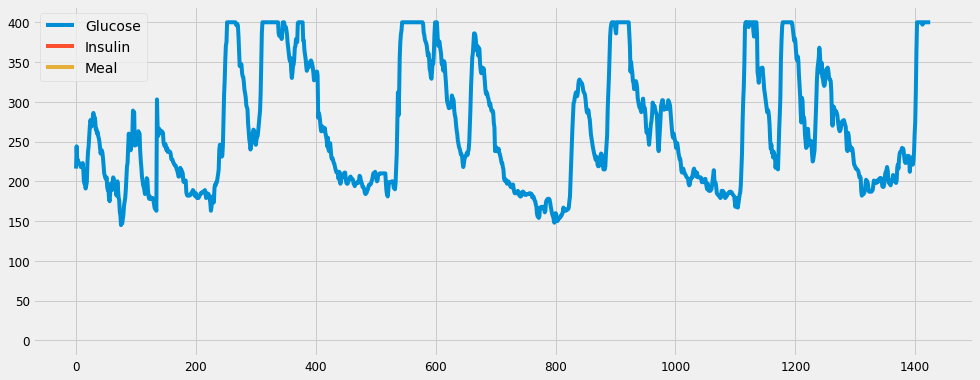

In [62]:
df.plot(figsize=(15,6))
plt.show()

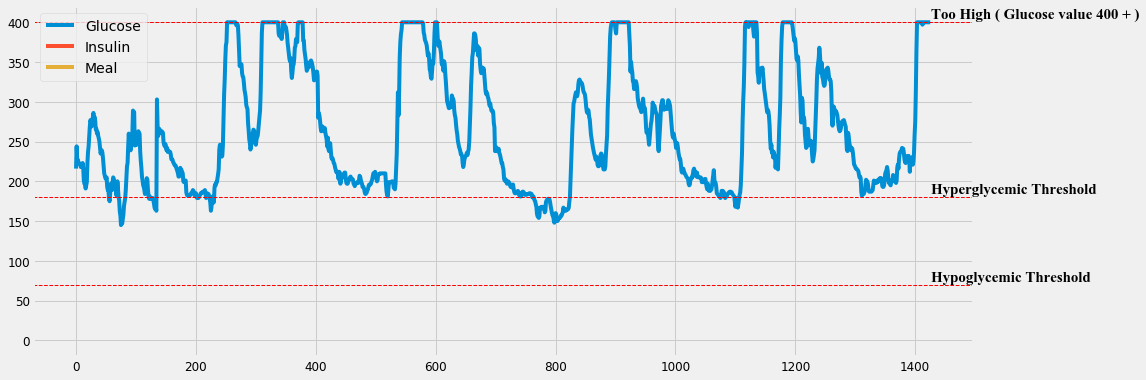

In [63]:
df.plot(figsize=(15,6))
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
#plt.annotate(df['Timestamp'][13],xy=(-50,40),xytext=(-50,0),fontsize=20,bbox=dict(boxstyle='square',
#                                                               color='white'),arrowprops=dict(facecolor='black'))
#plt.annotate(df['Timestamp'][len(df['Timestamp'])],xytext=(-,0),fontsize=20,bbox=dict(boxstyle='square',
 #                                                              color='white'))
plt.text(len(df['Timestamp']),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

#y=70
#plt.plot(y,'b--',linestyles='--'),
#plt.hlines(70,linestyles='--')
plt.show()

In [64]:
#df.drop(0,inplace=True)

In [65]:
# drop한 인스턴스가 있어서 인덱스 리셋
#df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
#df=df.reset_index(drop=True)
#df.head(21)

In [66]:
# 인슐린, 탄수화물 투여시 혈당값 NULL
# 그래서 t시점에 t-2 , t-1 크기비교해서 upper면 이렇게 lower면 이렇게 해서 interpolation ( 보간)
# 이거 위에 참고사항 drop하고 나서 적용 해줘야됨
#insul=list()
#import math
#def interpolate_glucose(df,col):
#    #insul=list()
    
#    for i, row in df.iterrows():
#        val=row[col]
#        if math.isnan(val):
#            if df['Glucose'][i-2] >= df['Glucose'][i-1]:
#                c = (df['Glucose'][i-2] - df['Glucose'][i-1]) / 2 
#                df.loc[i,col]= df['Glucose'][i-1] - c
#                insul.append(i)
#                print(insul)
                
#            if df['Glucose'][i-2] < df['Glucose'][i-1]:
#                c = (df['Glucose'][i-2] - df['Glucose'][i-1]) / 2 
#                df.loc[i,col]= df['Glucose'][i-1] - c
#                insul.append(i)
#                print(insul)
        
           

In [67]:
# 인슐린 탄수화물 인덱스 문제 해결 파트 
#insul=list()
#meal=list()
#import math
#def interpolate_glucose(df,col):
    #insul=list()
    
#    for i, row in df.iterrows():
#        val=row[col]
        #df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
        #df=df.reset_index(drop=True)
#        if math.isnan(val):
 #           if df['Event'][i]=='인슐린':
  #              if df['Glucose'][i-1] is None:
   #                 insul.append(i-2)
                    
                    
    #            else:
     #               insul.append(i-1)
                    
      #      if df['Event'][i]=='탄수화물':
       #         if df['Glucose'][i-1] is None:
        #            meal.append(i-2)
                    
         #       else:
          #          meal.append(i-1)
                    

In [68]:
#interpolate_glucose(df,'Glucose')

In [69]:
#meal

In [70]:
#insul

In [71]:
df[10:20]

Timestamp Event Glucose  Insulin  Meal
10  2020-03-13T11:55:50   EGV     218      NaN   NaN
11  2020-03-13T12:00:51   EGV     223      NaN   NaN
12  2020-03-13T12:05:50   EGV     217      NaN   NaN
13  2020-03-13T12:10:50   EGV     201      NaN   NaN
14  2020-03-13T12:15:50   EGV     197      0.0   0.0
15  2020-03-13T12:20:50   EGV     196      NaN   NaN
16  2020-03-13T12:25:50   EGV     191      NaN   NaN
17  2020-03-13T12:30:49   EGV     195      NaN   NaN
18  2020-03-13T12:35:50   EGV     199      NaN   NaN
19  2020-03-13T12:40:51   EGV     223      NaN   NaN

In [72]:
insul_glucose_value=list()
for i in new_insul_list:
    insul_glucose_value.append(df['Glucose'][i])

In [73]:
meal_glucose_value=list()
for i in new_meal_list:
    meal_glucose_value.append(df['Glucose'][i])

In [74]:
insul_and_meal_glucose_value = list()
for i in new_insul_and_meal_list:
    insul_and_meal_glucose_value.append(df['Glucose'][i])

In [75]:
#len = len(df['Timestamp'])
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


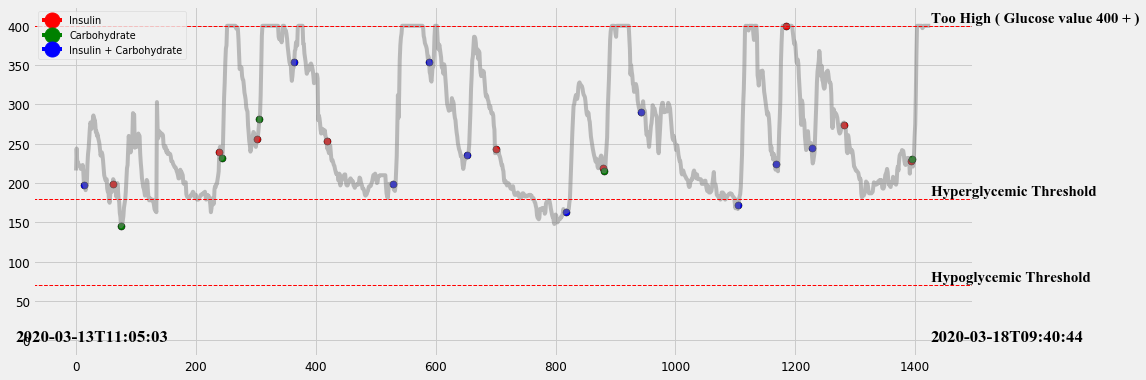

In [76]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

df.plot(figsize=(15,6),color='gray',alpha=0.5)
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
#plt.axhline(y=60,c='black',linestyle='--',linewidth=1)
plt.text(len(df['Timestamp']),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)

plt.scatter(new_insul_list,insul_glucose_value,edgecolor='black',s=50,label='Insulin',marker='o',c='red')
plt.scatter(new_meal_list,meal_glucose_value,edgecolor='black',s=50,label='Carbohydrate',marker='o',c='green')
plt.scatter(new_insul_and_meal_list,insul_and_meal_glucose_value,edgecolor='black',s=50,label='Insulin + Carbohydrate',marker='o',c='blue')

red_patch = mpatches.Patch(color='red',label='Insulin')

red_line = mlines.Line2D([],[],color='red',marker='o',markersize=15,label='Insulin')
green_line = mlines.Line2D([],[],color='green',marker='o',markersize=15,label='Carbohydrate')
blue_line = mlines.Line2D([],[],color='blue',marker='o',markersize=15,label='Insulin + Carbohydrate')
plt.text(len(df['Timestamp']),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),60,'',family='Times New Roman',size=15)
#plt.text(len(df['Timestamp']),-1,df['Timestamp'][len(df['Timestamp'])],family='Times New Roman',
#         fontweight='bold',size=20)
plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp']),-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.legend(['Insulin','Carbohydrate','Insulin + Carbohydrate'],loc='best',fontsize='x-small',handles=[red_line,green_line,blue_line])
#plt.text(-100,-1,df['Timestamp'][14],family='Times New Roman',

#         fontweight='bold',size=20)

#y=70
#plt.plot(y,'b--',linestyles='--'),
#plt.hlines(70,linestyles='--')
plt.show()

In [77]:
for i in range(len(df)):
    if isNaN(df['Insulin'][i]):
        df['Insulin'][i]=1
    else:
        df['Insulin'][i]=0
        
     

In [78]:
for i in range(len(df)):
    if isNaN(df['Meal'][i]):
        df['Meal'][i]=1
    else:
        df['Meal'][i]=0
        

In [79]:
df.head(20)

Timestamp Event Glucose  Insulin  Meal
0   2020-03-13T11:05:03    교정     216      0.0   0.0
1   2020-03-13T11:14:06    교정     244      0.0   0.0
2   2020-03-13T11:15:55   EGV     227      0.0   0.0
3   2020-03-13T11:20:50   EGV     227      0.0   0.0
4   2020-03-13T11:25:49   EGV     224      0.0   0.0
5   2020-03-13T11:30:49   EGV     223      0.0   0.0
6   2020-03-13T11:35:49   EGV     222      0.0   0.0
7   2020-03-13T11:40:50   EGV     222      0.0   0.0
8   2020-03-13T11:45:51   EGV     218      0.0   0.0
9   2020-03-13T11:50:49   EGV     218      0.0   0.0
10  2020-03-13T11:55:50   EGV     218      0.0   0.0
11  2020-03-13T12:00:51   EGV     223      0.0   0.0
12  2020-03-13T12:05:50   EGV     217      0.0   0.0
13  2020-03-13T12:10:50   EGV     201      0.0   0.0
14  2020-03-13T12:15:50   EGV     197      1.0   1.0
15  2020-03-13T12:20:50   EGV     196      0.0   0.0
16  2020-03-13T12:25:50   EGV     191      0.0   0.0
17  2020-03-13T12:30:49   EGV     195      0.0   0.0
18  2020-03-13T12:35:50   EGV     199      0.0   0.0
19  2020-03-13T12:40:51   EGV     223      0.0   0.0

## 이제 여기부터 DL 모델 돌려볼 것 
+ 일단 모델부터 간단하게 돌려보고 성능 측정
+ 그리고 전처리 해가면서 성능 비교

In [80]:
import numpy as np
import tensorflow as tf
import random as rn

In [81]:
# 재현 가능한 결과를 만들기 위해 시드값 설정 
import os 
import random
seed_num = 42
os.environ['PYTHONHASHSEED']=str(seed_num)

random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

In [82]:
from tensorflow.compat.v1.keras import backend as K

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [83]:
#from keras import backend as K
#session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#tf.compat.v1.keras.backend.set_session(sess)


In [84]:
from sklearn.metrics import mean_squared_error
def RMSE(y_test,y_predict):
    return np.sqrt(mean_squared_error(y_test,y_predict))

In [85]:
from numpy import array
from numpy import hstack
in_seq1=df['Glucose'].to_numpy()
in_seq2 =df['Meal'].to_numpy()
in_seq3 =df['Insulin'].to_numpy()
out_seq = array([in_seq1[i]+in_seq2[i]+in_seq3[i] for i in range(len(in_seq1))])

In [86]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

In [87]:
dataset = hstack((in_seq1,in_seq2,in_seq3))

In [88]:
dataset = np.asarray(dataset).astype(np.float32)

## 15분

In [89]:
def multi_data(dataset,target,start_index,end_index, history_size, target_size, step, single_step=False):
    data=[]
    labels=[]
    
    start_index= start_index+history_size
    if end_index is None:
    #if end_index > len(dataset)-1:
        end_index = len(dataset)-target_size
        
    for i in range(start_index,end_index):
        indices = range(i-history_size,i, step)
        
        data.append(dataset[indices])
        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
        #data.append(np.reshape(dataset[indices],(history_size)))
        #labels.append(dataset[i+target_size])
    return np.array(data),np.array(labels)

In [90]:
raw_seq = in_seq1
#raw_seq=raw_seq.to_numpy(dtype='int64')

In [91]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
multi_past_history = 6
multi_future_target = 2
STEP=1
x_train_single, y_train_single = multi_data(dataset,dataset[:,0],0,TRAIN_SPLIT,
                                            multi_past_history,multi_future_target,STEP,single_step=True)
x_val_single, y_val_single = multi_data(dataset, dataset[:,0],TRAIN_SPLIT,
                                        None,multi_past_history,multi_future_target,STEP,single_step=True)

In [92]:
df.head(20)

Timestamp Event Glucose  Insulin  Meal
0   2020-03-13T11:05:03    교정     216      0.0   0.0
1   2020-03-13T11:14:06    교정     244      0.0   0.0
2   2020-03-13T11:15:55   EGV     227      0.0   0.0
3   2020-03-13T11:20:50   EGV     227      0.0   0.0
4   2020-03-13T11:25:49   EGV     224      0.0   0.0
5   2020-03-13T11:30:49   EGV     223      0.0   0.0
6   2020-03-13T11:35:49   EGV     222      0.0   0.0
7   2020-03-13T11:40:50   EGV     222      0.0   0.0
8   2020-03-13T11:45:51   EGV     218      0.0   0.0
9   2020-03-13T11:50:49   EGV     218      0.0   0.0
10  2020-03-13T11:55:50   EGV     218      0.0   0.0
11  2020-03-13T12:00:51   EGV     223      0.0   0.0
12  2020-03-13T12:05:50   EGV     217      0.0   0.0
13  2020-03-13T12:10:50   EGV     201      0.0   0.0
14  2020-03-13T12:15:50   EGV     197      1.0   1.0
15  2020-03-13T12:20:50   EGV     196      0.0   0.0
16  2020-03-13T12:25:50   EGV     191      0.0   0.0
17  2020-03-13T12:30:49   EGV     195      0.0   0.0
18  2020-03-13T12:35:50   EGV     199      0.0   0.0
19  2020-03-13T12:40:51   EGV     223      0.0   0.0

### RNN - 15분

In [93]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [94]:
from keras.layers import SimpleRNN

In [95]:
n_steps = 3
#delay=3
n_features=1

In [96]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)


In [97]:
x_train_single.shape[-2:]

(6, 3)

In [98]:
K.set_session(sess)

In [99]:
model = Sequential()
#model.add(SimpleRNN(50,activation='relu',input_shape=x_train_single.shape[-2:],return_sequences=False))
model.add(SimpleRNN(50,activation='relu',input_shape=x_train_single.shape[-2:],return_sequences=False))
model.add(Dense(1))

In [100]:
model.compile(optimizer='adam',loss='mse')

In [101]:
model.fit(x_train_single,y_train_single,epochs=200,verbose=0)

In [102]:
K.clear_session()

In [103]:
predict_result = model.predict(x_val_single,verbose=0)

In [104]:
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

In [105]:
# Val set RMSE 
print(' Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_val_single,predict_result))
val_rnn_15 = RMSE(y_val_single,predict_result)


 Vanila RNN (Simple RNN) - RMSE (15min) :  19.742668


#### Validation

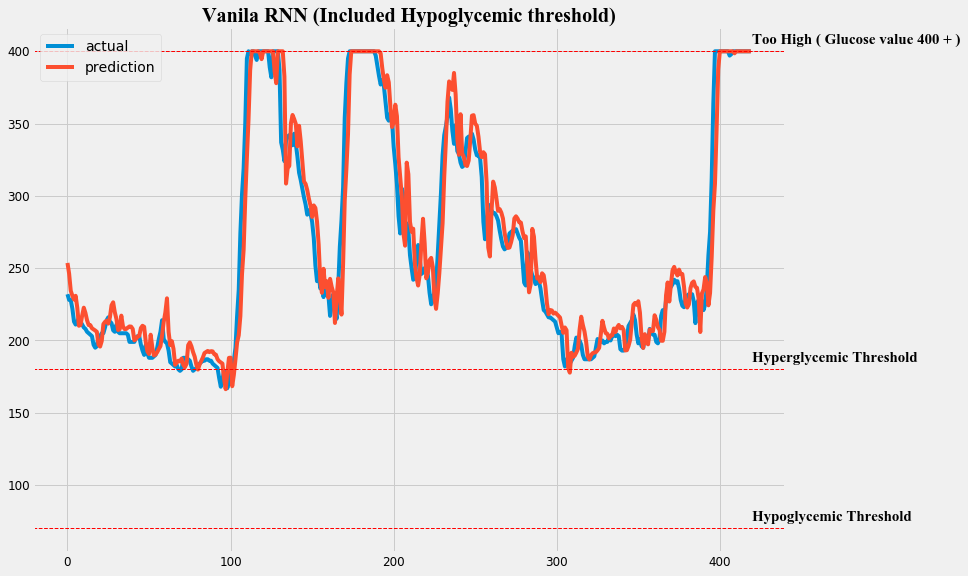

In [106]:
plt.figure(figsize=(12,9))
plt.plot(y_val_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.title('Vanila RNN (Included Hypoglycemic threshold)',family='Times New Roman')
plt.legend()
plt.show()

In [107]:
from pandas import DataFrame
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import probplot

#residuals=DataFrame(residuals)

Text(0.5, 1.0, 'Simple RNN Normal Q-Q Plot')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


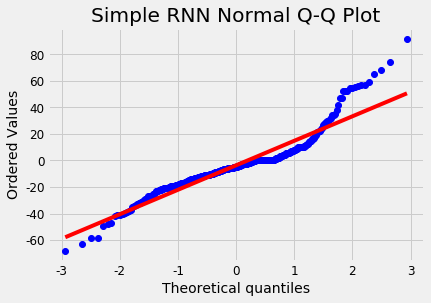

In [108]:
residuals = [y_val_single[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_single - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Normal Q-Q Plot")

#### 잔차

Text(0.5, 1.0, 'Simple RNN Normal Q-Q Plot')

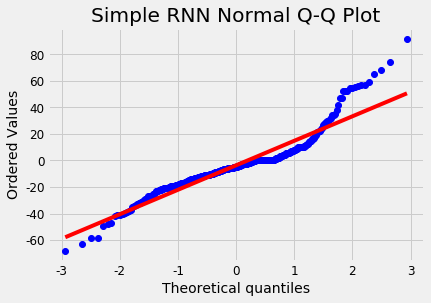

In [109]:
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Normal Q-Q Plot")

In [110]:
residuals=DataFrame(residuals)

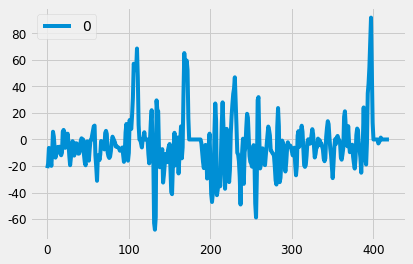

In [111]:
residuals.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028B3656CF08>]],
      dtype=object)

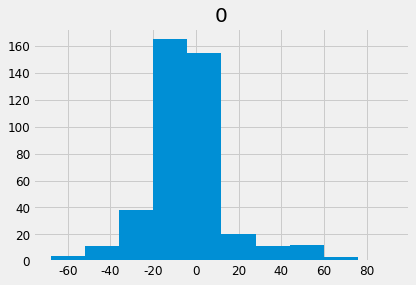

In [112]:

residuals.hist()

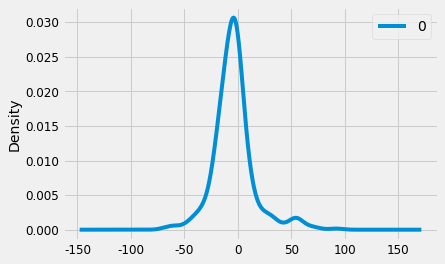

In [113]:
residuals.plot(kind='kde')

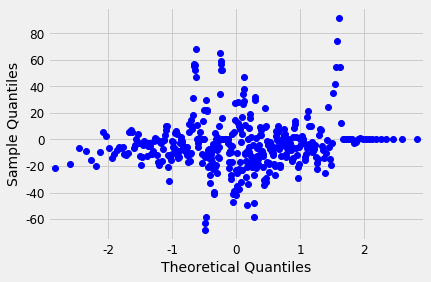

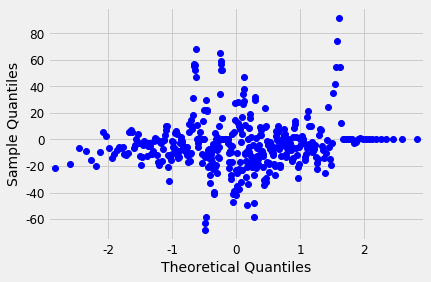

In [114]:
from statsmodels.graphics.gofplots import qqplot
residuals=np.array(residuals)
qqplot(residuals)

In [115]:
# 트레이닝셋 rmse 구하는 부분 
predict_result = model.predict(x_train_single,verbose=0)
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400            
print(' Training set / Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_train_single,predict_result))
train_rnn_15=RMSE(y_train_single,predict_result)

 Training set / Vanila RNN (Simple RNN) - RMSE (15min) :  17.73093


#### Train

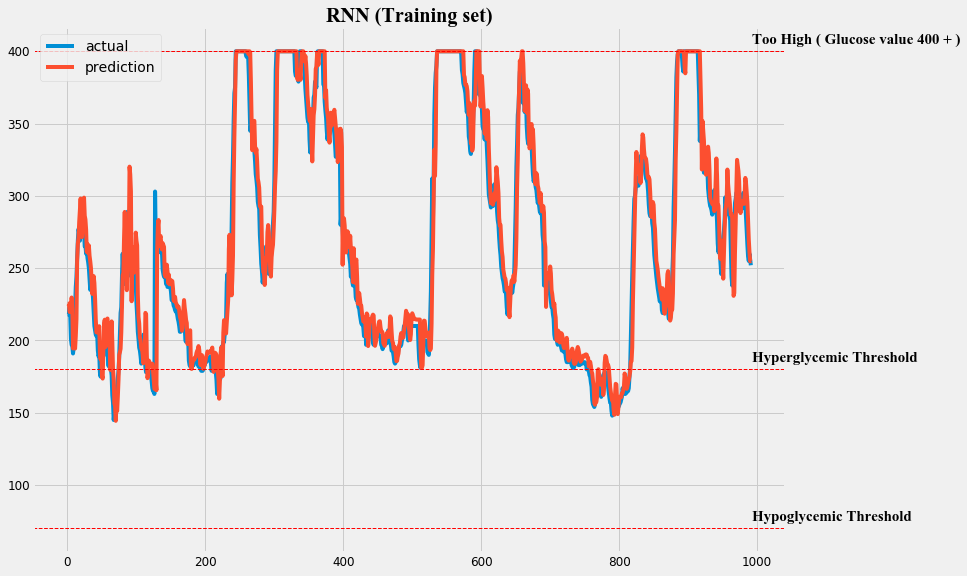

In [116]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.title('RNN (Training set)',family='Times New Roman')
plt.legend()
plt.show()

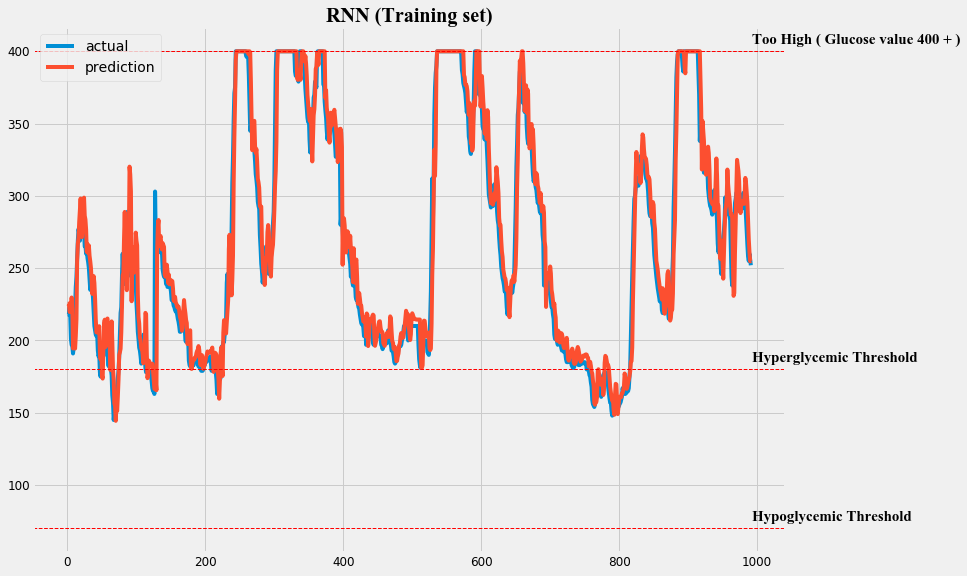

In [117]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('RNN (Training set)',family='Times New Roman')
plt.legend()
plt.show()

### LSTM - 15분

In [118]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [119]:
model = Sequential()
model.add(LSTM(50,activation='relu',input_shape=x_train_single.shape[-2:]))
model.add(Dense(1))


In [120]:
model.compile(optimizer='adam',loss='mse')

In [121]:
model.fit(x_train_single,y_train_single,epochs=200,verbose=0)

In [122]:
K.clear_session()

In [123]:
predict_result = model.predict(x_val_single,verbose=0)

In [124]:
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

In [125]:
#predict_result

In [126]:
print(' LSTM - RMSE (15min) : ',RMSE(y_val_single,predict_result))
val_lstm_15=RMSE(y_val_single,predict_result)

 LSTM - RMSE (15min) :  20.086256


In [127]:
TRAIN_SPLIT

998

#### 잔차

Text(0.5, 1.0, 'LSTM Normal Q-Q Plot')

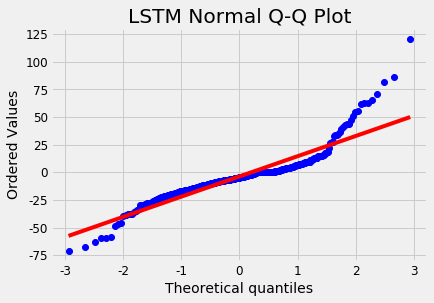

In [128]:
residuals = [y_val_single[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_single - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("LSTM Normal Q-Q Plot")

#### Validation

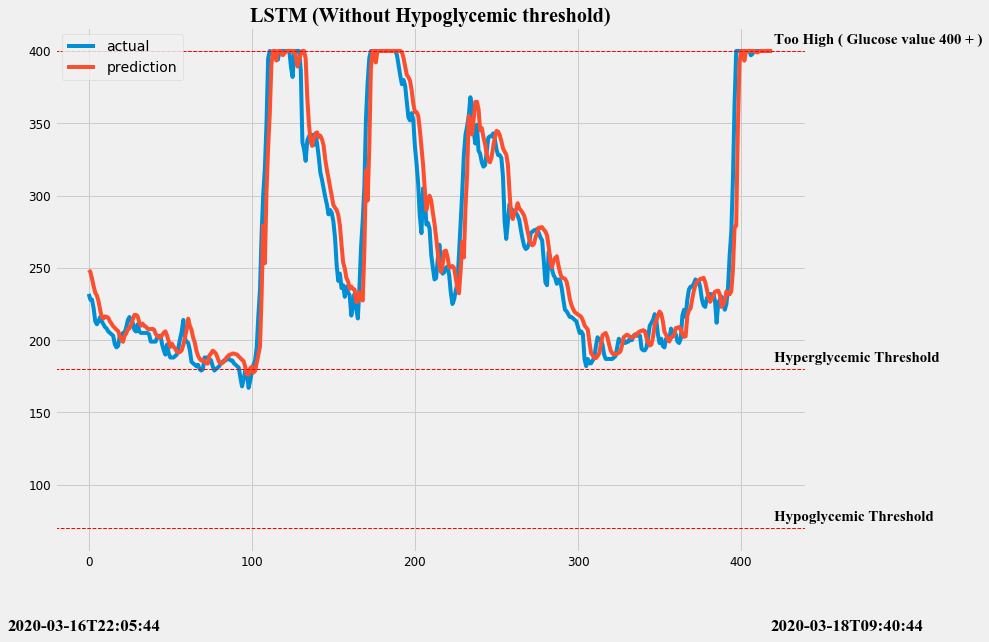

In [129]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM (Without Hypoglycemic threshold)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [130]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_single,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' LSTM - RMSE (15min) Training set : ',RMSE(y_train_single,predict_result))
train_lstm_15 =RMSE(y_train_single,predict_result)

 LSTM - RMSE (15min) Training set :  19.345827


#### Train

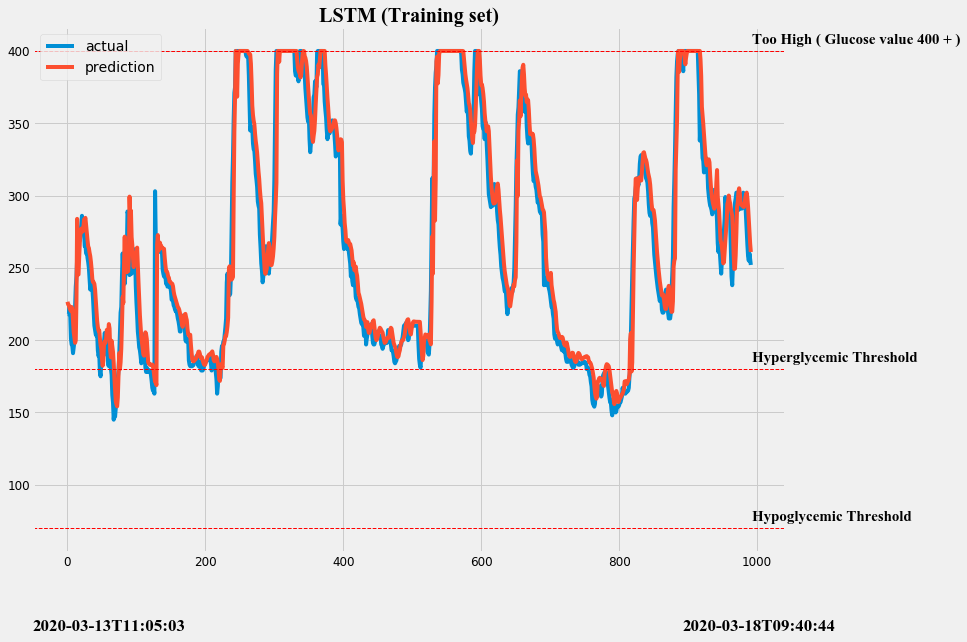

In [131]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM (Training set)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend()
plt.show()

### Stacked LSTM - 15분

In [132]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [133]:
model = Sequential()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=x_train_single.shape[-2:]))
model.add(LSTM(50,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [134]:
model.fit(x_train_single,y_train_single,epochs=200,verbose=0)

In [135]:
K.clear_session()

In [136]:
predict_result = model.predict(x_val_single,verbose=0)


In [137]:
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

In [138]:
print(' Stacked LSTM - RMSE(15min) : ',RMSE(y_val_single,predict_result))
val_stacklstm_15 =RMSE(y_val_single,predict_result)

 Stacked LSTM - RMSE(15min) :  17.331167


#### Validation

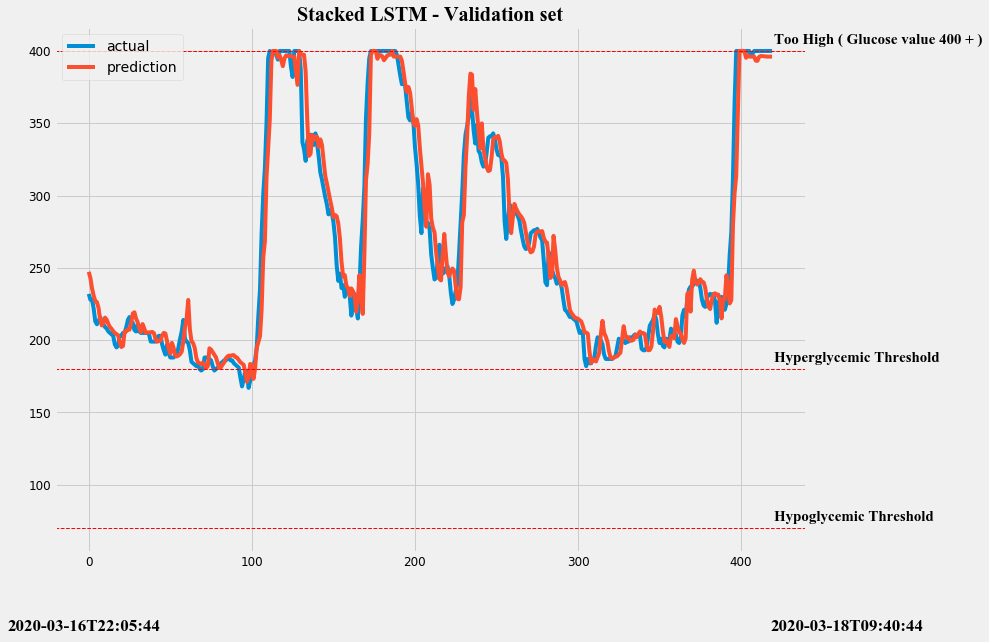

In [139]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

#### 잔차

Text(0.5, 1.0, 'Stacked LSTM Normal Q-Q Plot')

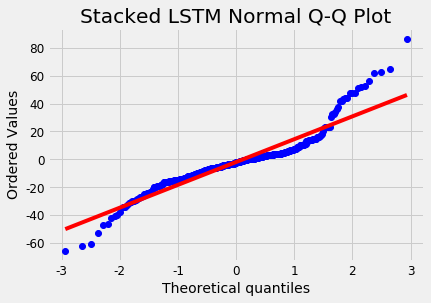

In [140]:
residuals = [y_val_single[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_single - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Stacked LSTM Normal Q-Q Plot")

In [141]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_single,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / STACKED LSTM - RMSE (15min) Training set : ',RMSE(y_train_single,predict_result))
train_stacklstm_15 = RMSE(y_train_single,predict_result)

 Training set / STACKED LSTM - RMSE (15min) Training set :  16.440697


#### Train

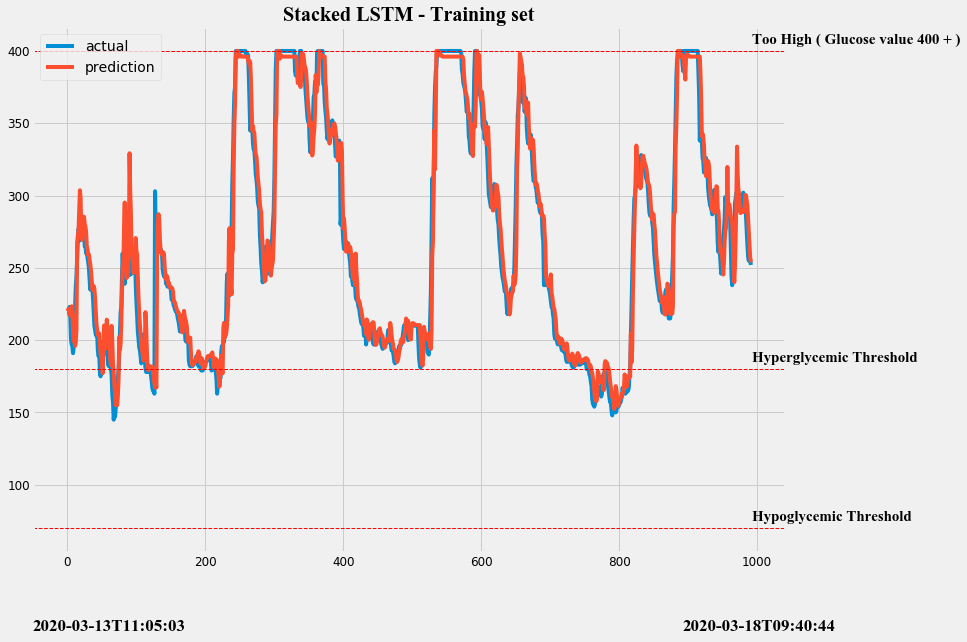

In [142]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### Bidirectional LSTM - 15분

In [143]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [144]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(50,activation='relu'),input_shape=x_train_single.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [145]:
model.fit(x_train_single,y_train_single,epochs=200,verbose=0)

In [146]:
K.clear_session()

In [147]:
predict_result = model.predict(x_val_single,verbose=0)

In [148]:
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

In [149]:
print('Bidirectional LSTM - RMSE : ',RMSE(y_val_single,predict_result))
val_bilstm_15 = RMSE(y_val_single,predict_result)

Bidirectional LSTM - RMSE :  19.469698


#### 잔차

Text(0.5, 1.0, 'Bidirectional LSTM Normal Q-Q Plot')

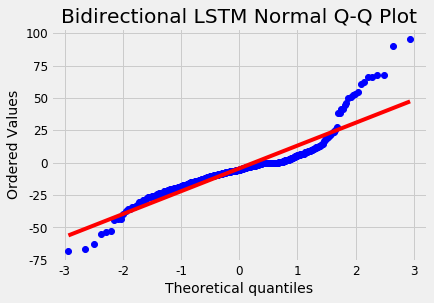

In [150]:
residuals = [y_val_single[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_single - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Bidirectional LSTM Normal Q-Q Plot")

#### Validation

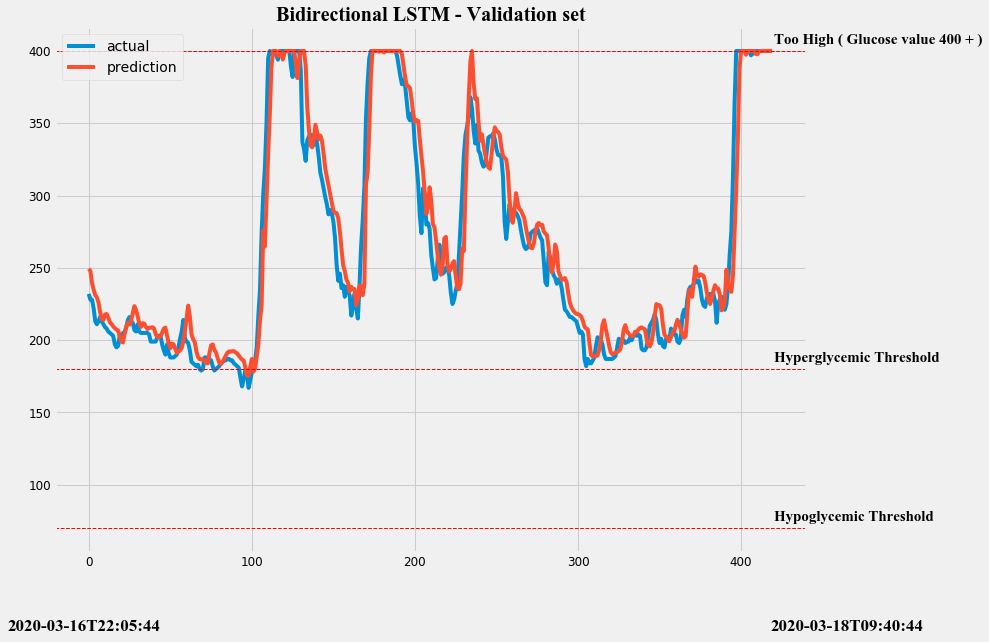

In [151]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [152]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_single,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / Bidirectional LSTM - RMSE (60min) Training set : ',RMSE(y_train_single,predict_result))
train_bilstm_15 = RMSE(y_train_single,predict_result)

 Training set / Bidirectional LSTM - RMSE (60min) Training set :  18.617098


#### Train

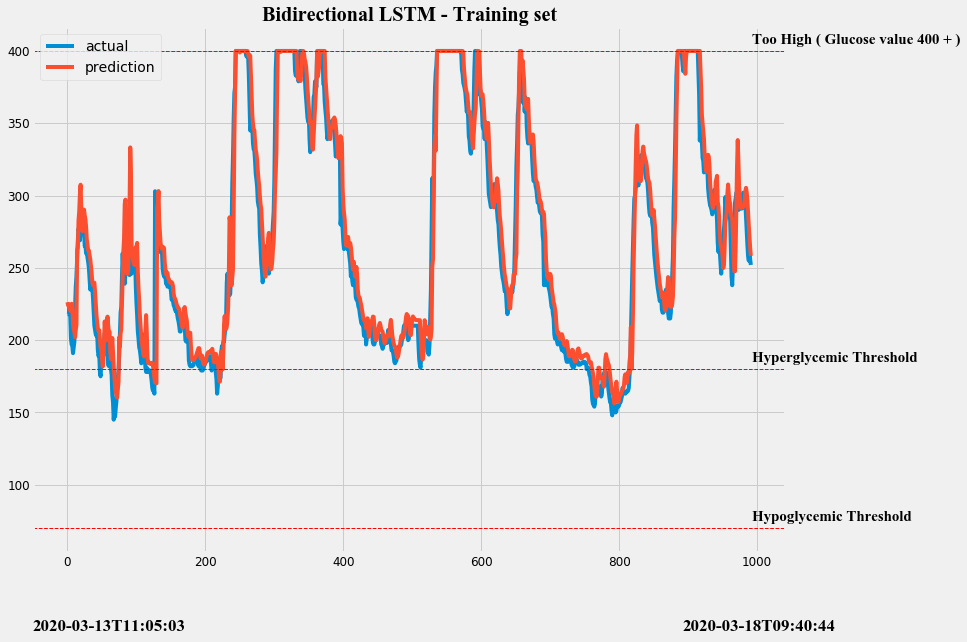

In [153]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GRU - 15분

In [154]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [155]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(50,activation='relu',input_shape=x_train_single.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [156]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                8250      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 8,301
Trainable params: 8,301
Non-trainable params: 0
_________________________________________________________________


In [157]:
model.fit(x_train_single,y_train_single,epochs=200,verbose=0)

In [158]:
K.clear_session()

In [159]:
predict_result = model.predict(x_val_single,verbose=0)

In [160]:
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

In [161]:
#predict_result

In [162]:
#predict_result

In [163]:

print('GRU - RMSE 15min : ',RMSE(y_val_single,predict_result))
val_gru_15 = RMSE(y_val_single,predict_result)
# 상한선 400일 때 RMSE - 38.30 
# 상한선 400 X - 38.63

GRU - RMSE 15min :  18.595892


#### 잔차

Text(0.5, 1.0, 'GRU Normal Q-Q Plot')

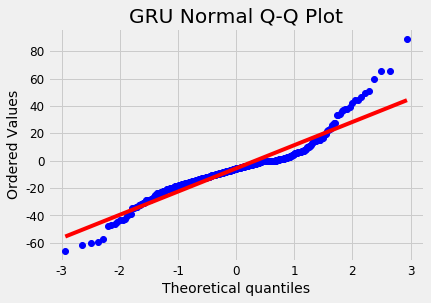

In [164]:
residuals = [y_val_single[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_single - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("GRU Normal Q-Q Plot")

#### Validation

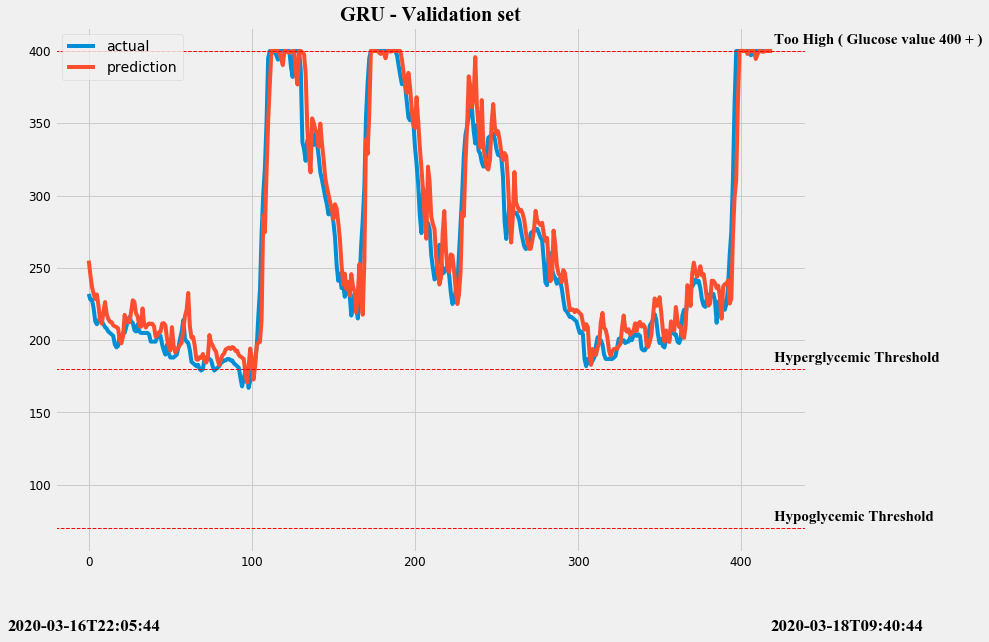

In [165]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [166]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_single,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / GRU - RMSE (15min) Training set : ',RMSE(y_train_single,predict_result))
train_gru_15 =RMSE(y_train_single,predict_result)

 Training set / GRU - RMSE (15min) Training set :  17.459606


#### Train

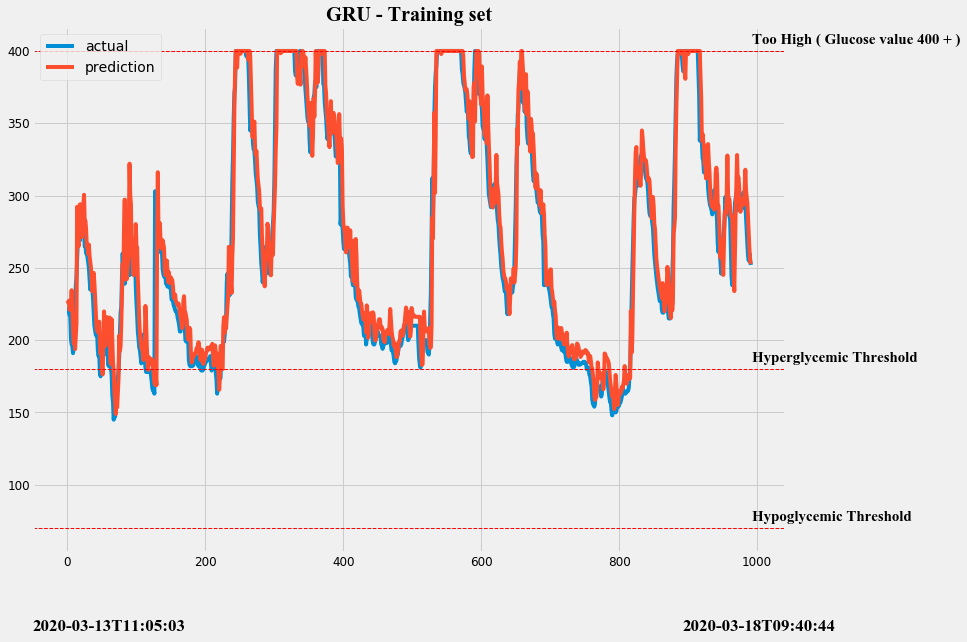

In [167]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

In [168]:
#from pandas import DataFrame
#residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
#residuals=DataFrame(residuals)
#residuals.hist()

In [169]:
#residuals.plot(kind='kde')

In [170]:
#residuals.plot()

In [171]:
#from statsmodels.graphics.gofplots import qqplot
#residuals=np.array(residuals)
#qqplot(residuals)

## 30분

In [172]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
multi_past_history = 6
multi_future_target = 5
STEP=1
x_train_single, y_train_single = multi_data(dataset,dataset[:,0],0,TRAIN_SPLIT,
                                            multi_past_history,multi_future_target,STEP,single_step=True)
x_val_single, y_val_single = multi_data(dataset, dataset[:,0],TRAIN_SPLIT,
                                        None,multi_past_history,multi_future_target,STEP,single_step=True)

In [173]:
#x_train_uni.shape


In [174]:

#x_val_uni.shape

In [175]:
#x_train_uni[0]

In [176]:
#df['Glucose'].head(15)

In [177]:
#y_train_uni[0]

### RNN - 30분

In [178]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [179]:
model = Sequential()
model.add(SimpleRNN(50,activation='relu',input_shape=x_train_single.shape[-2:],return_sequences=False))
model.add(Dense(1))

In [180]:
model.compile(optimizer='adam',loss='mse')

In [181]:
model.fit(x_train_single,y_train_single,epochs=200,verbose=0)

In [182]:
K.clear_session()

In [183]:
predict_result = model.predict(x_val_single,verbose=0)

In [184]:
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

In [185]:
# Val set RMSE 
print(' Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_val_single,predict_result))
val_rnn_30 = RMSE(y_val_single,predict_result)


 Vanila RNN (Simple RNN) - RMSE (15min) :  33.583378


#### 잔차

Text(0.5, 1.0, 'Simple RNN Q-Q Plot')

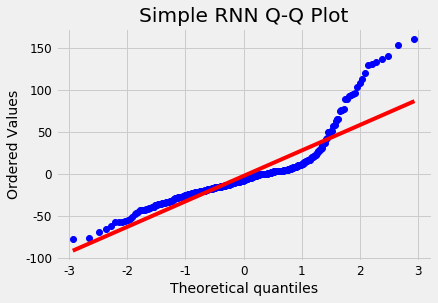

In [186]:
residuals = [y_val_single[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_single - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Q-Q Plot")

#### Validation

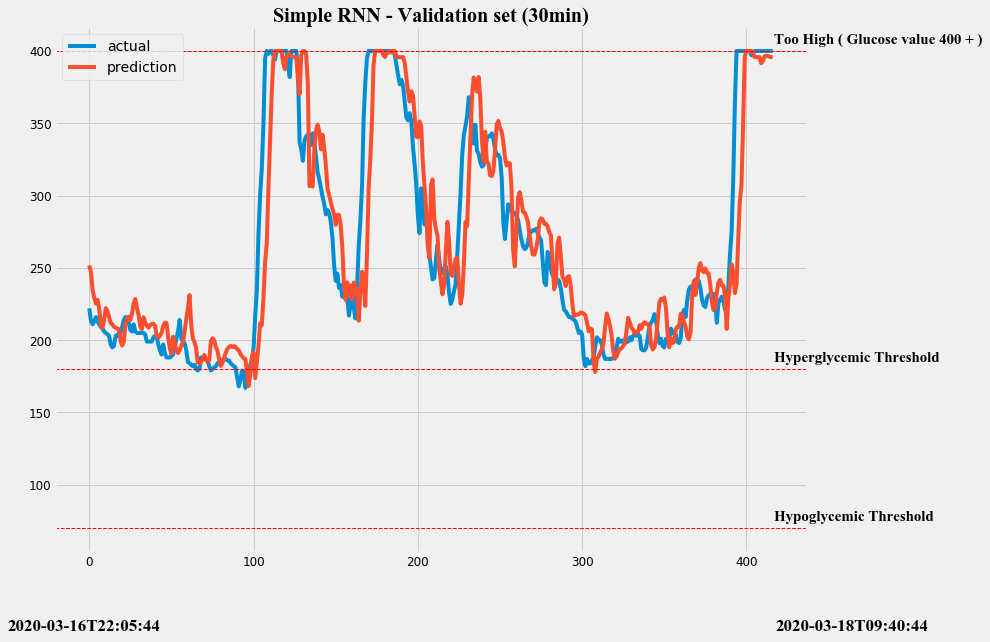

In [187]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

Text(0.5, 1.0, 'Simple RNN 30min Normal Q-Q Plot')

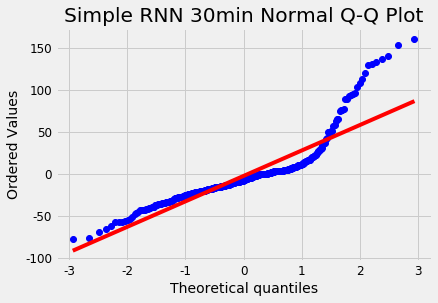

In [188]:
from pandas import DataFrame
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import probplot

#residuals=DataFrame(residuals)

residuals = [y_val_single[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_single - predict_result.reshape(-1)

#residuals

probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN 30min Normal Q-Q Plot")

In [189]:
# 트레이닝셋 rmse 구하는 부분 
predict_result = model.predict(x_train_single,verbose=0)
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400            
print(' Training set / Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_train_single,predict_result))
train_rnn_30=RMSE(y_train_single,predict_result)

 Training set / Vanila RNN (Simple RNN) - RMSE (15min) :  28.64826


#### Train

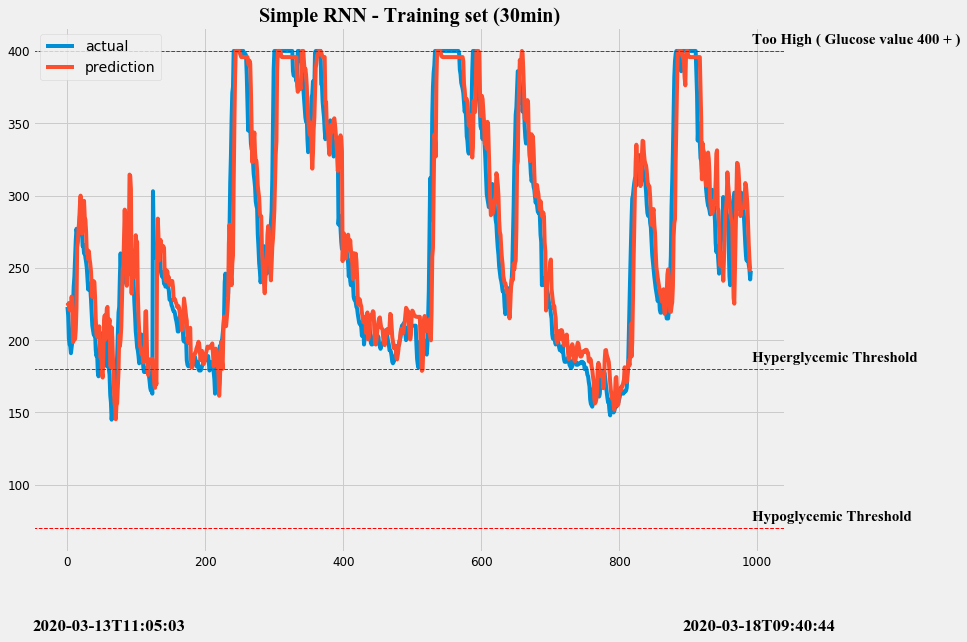

In [190]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Training set (30min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### LSTM - 30분

In [191]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [192]:
model = Sequential()
model.add(LSTM(50,activation='relu',input_shape=x_train_single.shape[-2:]))
model.add(Dense(1))


In [193]:
model.compile(optimizer='adam',loss='mse')

model.fit(x_train_single,y_train_single,epochs=200,verbose=0)

K.clear_session()

In [194]:
predict_result = model.predict(x_val_single,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

#predict_result

print(' LSTM - RMSE (15min) : ',RMSE(y_val_single,predict_result))
val_lstm_30=RMSE(y_val_single,predict_result)

 LSTM - RMSE (15min) :  28.508337


#### 잔차

Text(0.5, 1.0, 'LSTM Q-Q Plot')

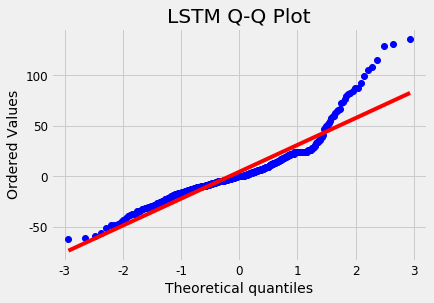

In [195]:
residuals = [y_val_single[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_single - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("LSTM Q-Q Plot")

#### Validation

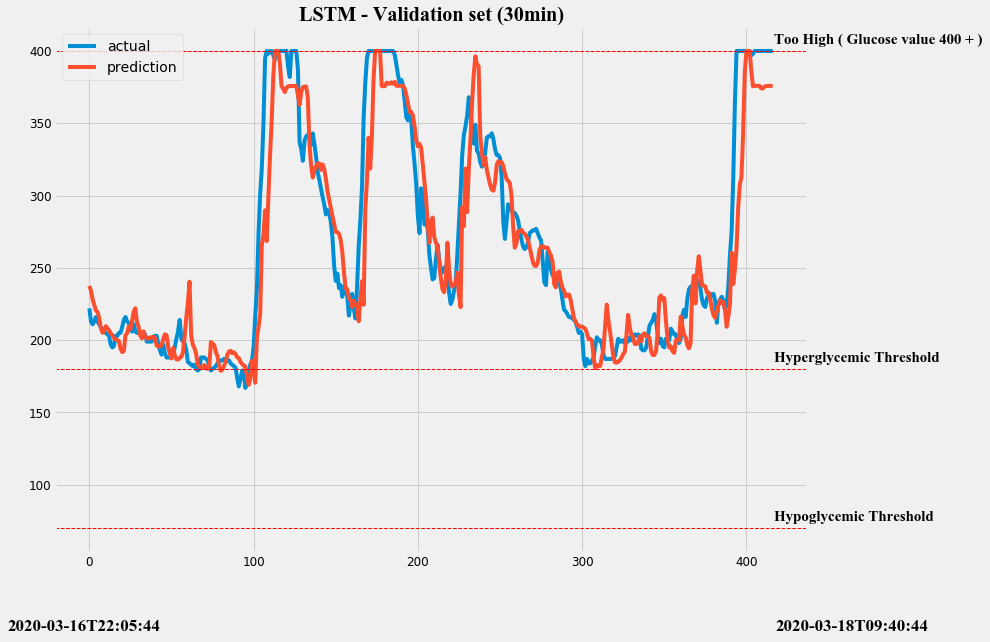

In [196]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [197]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_single,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' LSTM - RMSE (15min) Training set : ',RMSE(y_train_single,predict_result))
train_lstm_30 =RMSE(y_train_single,predict_result)

 LSTM - RMSE (15min) Training set :  26.845943


#### Train

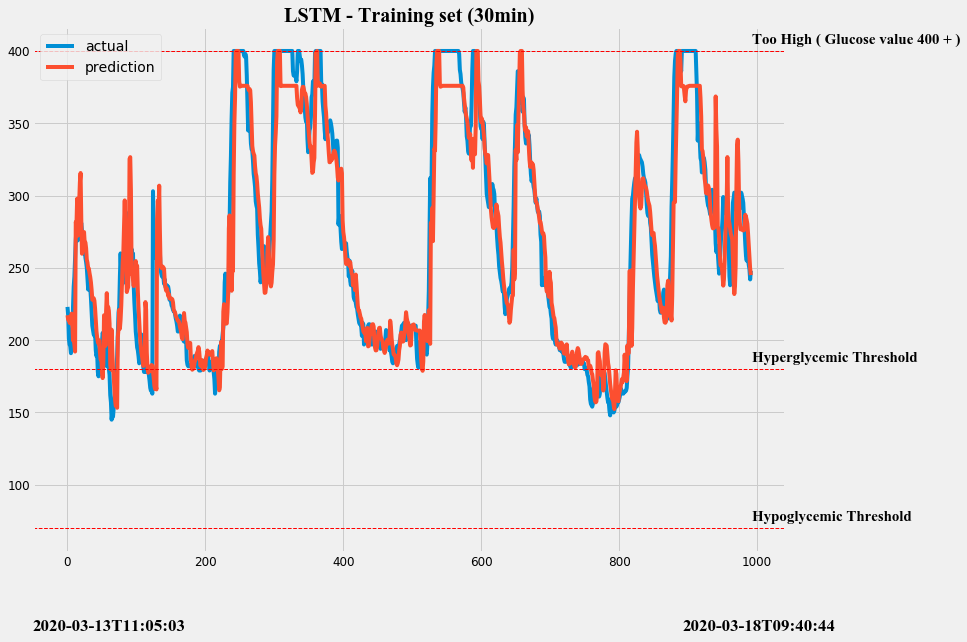

In [198]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Training set (30min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend()
plt.show()

### Stacked LSTM - 30분

In [199]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [200]:
model = Sequential()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=x_train_single.shape[-2:]))
model.add(LSTM(50,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [201]:
model.fit(x_train_single,y_train_single,epochs=200,verbose=0)

In [202]:
K.clear_session()

In [203]:
predict_result = model.predict(x_val_single,verbose=0)


for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

print(' Stacked LSTM - RMSE(15min) : ',RMSE(y_val_single,predict_result))
val_stacklstm_30 =RMSE(y_val_single,predict_result)

 Stacked LSTM - RMSE(15min) :  25.48538


#### 잔차

Text(0.5, 1.0, 'Stacked LSTM Q-Q Plot')

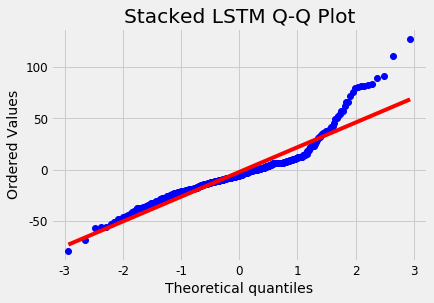

In [204]:
residuals = [y_val_single[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_single - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Stacked LSTM Q-Q Plot")

#### Validation

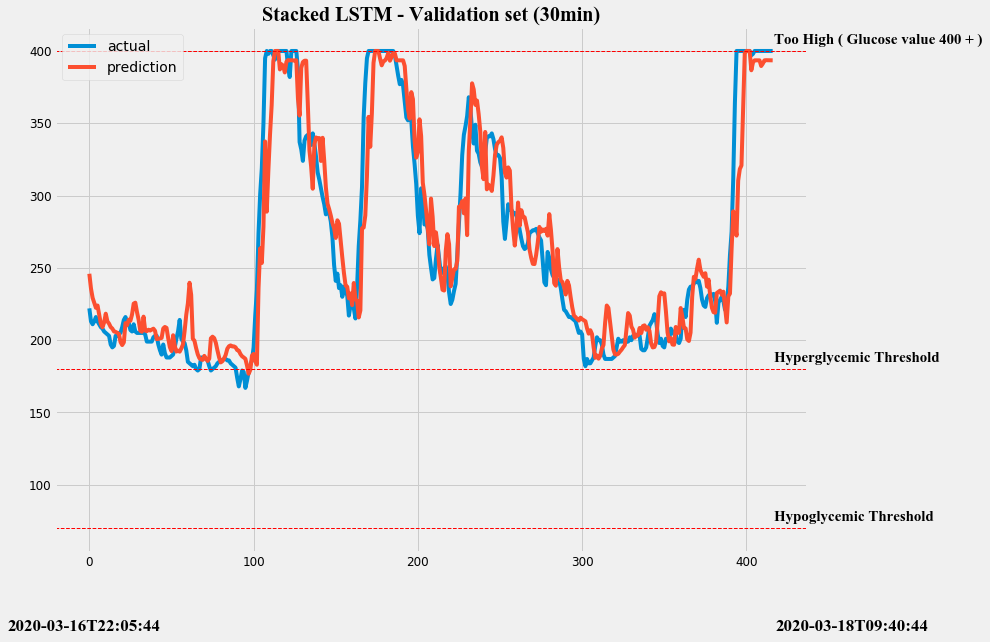

In [205]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [206]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_single,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / STACKED LSTM - RMSE (15min) Training set : ',RMSE(y_train_single,predict_result))
train_stacklstm_30 = RMSE(y_train_single,predict_result)

 Training set / STACKED LSTM - RMSE (15min) Training set :  25.544704


#### Train

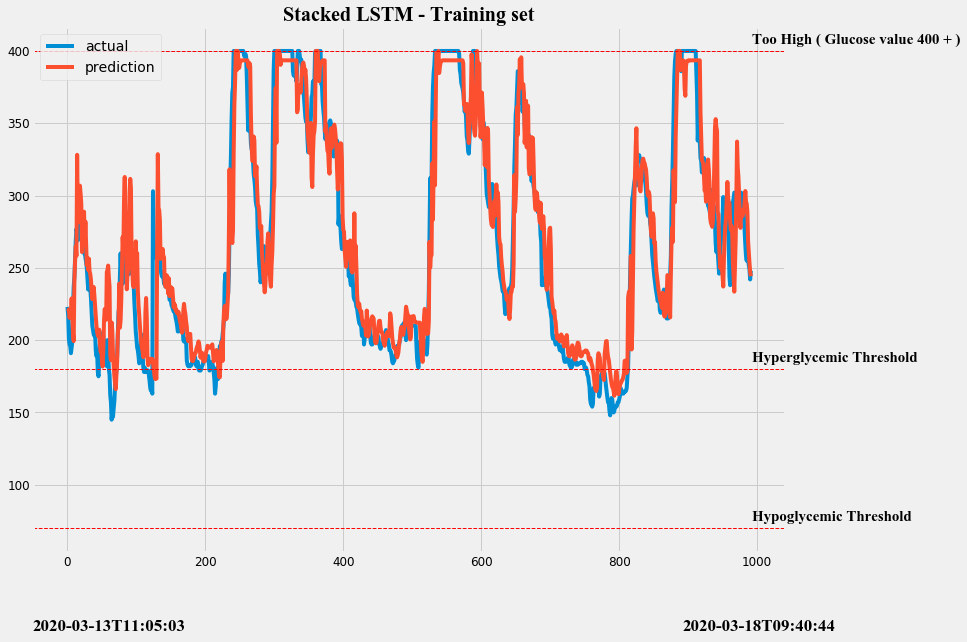

In [207]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### Bidirectional LSTM - 30분

In [208]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [209]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(50,activation='relu'),input_shape=x_train_single.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [210]:
model.fit(x_train_single,y_train_single,epochs=200,verbose=0)

In [211]:
K.clear_session()

In [212]:
predict_result = model.predict(x_val_single,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

print('Bidirectional LSTM - RMSE : ',RMSE(y_val_single,predict_result))
val_bilstm_30 = RMSE(y_val_single,predict_result)

Bidirectional LSTM - RMSE :  25.802187


#### 잔차

Text(0.5, 1.0, 'Bidirectional LSTM Q-Q Plot')

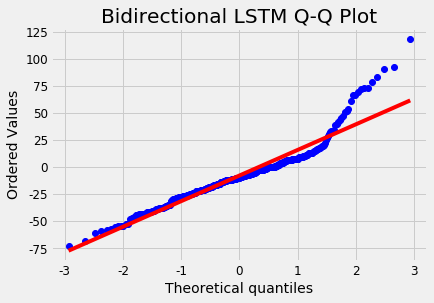

In [213]:
residuals = [y_val_single[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_single - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Bidirectional LSTM Q-Q Plot")

#### Validation

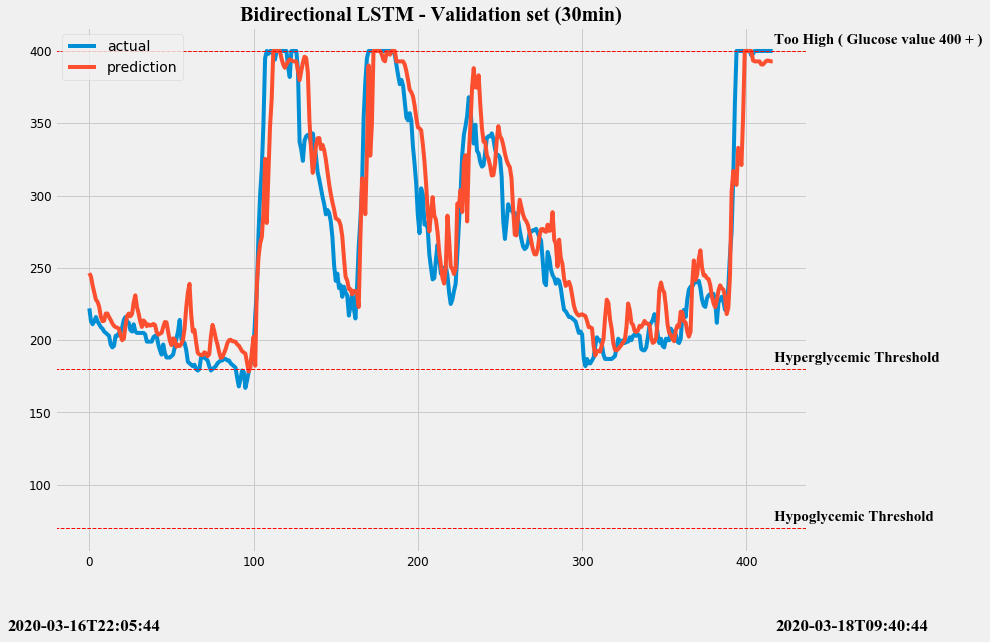

In [214]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [215]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_single,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / Bidirectional LSTM - RMSE (30min) Training set : ',RMSE(y_train_single,predict_result))
train_bilstm_30 = RMSE(y_train_single,predict_result)

 Training set / Bidirectional LSTM - RMSE (30min) Training set :  26.487843


#### Train

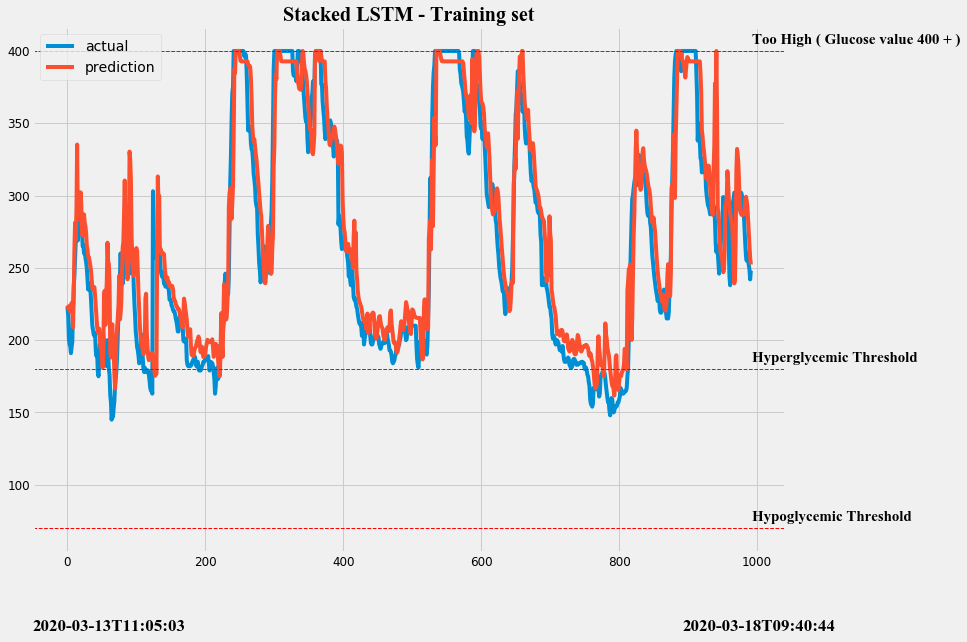

In [216]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GRU - 30분

In [217]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [218]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(50,activation='relu',input_shape=x_train_single.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [219]:
model.summary()

model.fit(x_train_single,y_train_single,epochs=200,verbose=0)

K.clear_session()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                8250      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 8,301
Trainable params: 8,301
Non-trainable params: 0
_________________________________________________________________


In [220]:
predict_result = model.predict(x_val_single,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

#predict_result

#predict_result


print('GRU - RMSE 15min : ',RMSE(y_val_single,predict_result))
val_gru_30 = RMSE(y_val_single,predict_result)
# 상한선 400일 때 RMSE - 38.30 
# 상한선 400 X - 38.63

GRU - RMSE 15min :  31.233986


#### 잔차

Text(0.5, 1.0, 'GRU Q-Q Plot')

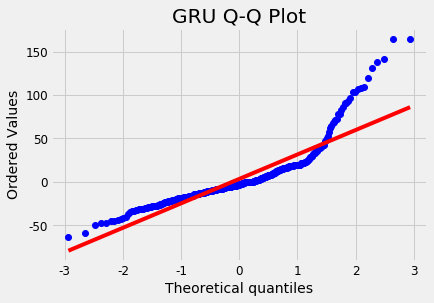

In [221]:
residuals = [y_val_single[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_single - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("GRU Q-Q Plot")

#### Validation

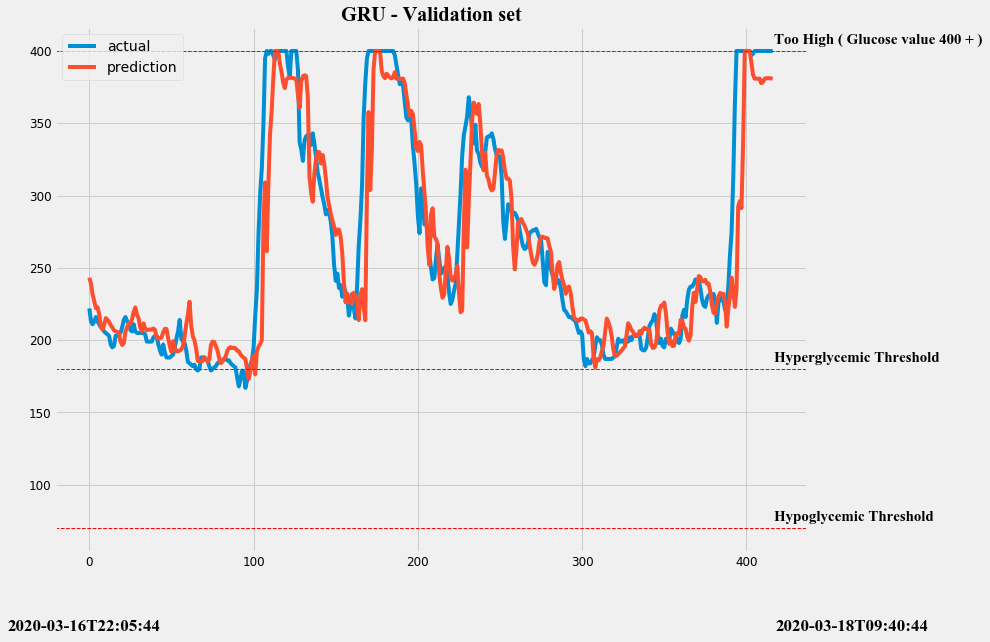

In [222]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [223]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_single,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / GRU - RMSE (15min) Training set : ',RMSE(y_train_single,predict_result))
train_gru_30 =RMSE(y_train_single,predict_result)

 Training set / GRU - RMSE (15min) Training set :  28.369259


#### Train

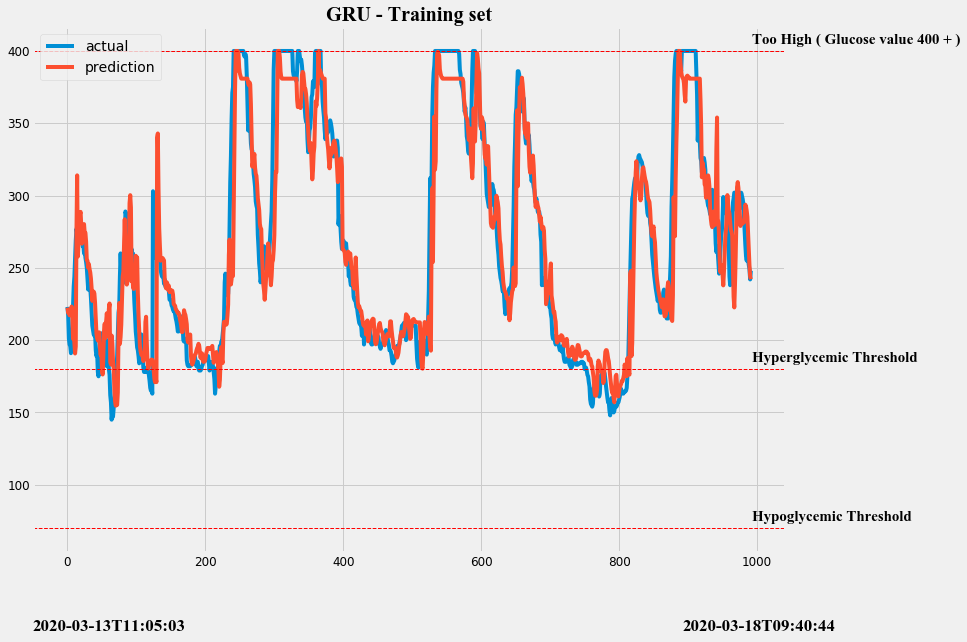

In [224]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

## 60분

In [225]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
multi_past_history = 6
multi_future_target = 11
STEP=1
x_train_single, y_train_single = multi_data(dataset,dataset[:,0],0,TRAIN_SPLIT,
                                            multi_past_history,multi_future_target,STEP,single_step=True)
x_val_single, y_val_single = multi_data(dataset, dataset[:,0],TRAIN_SPLIT,
                                        None,multi_past_history,multi_future_target,STEP,single_step=True)

In [226]:
#x_train_uni[0]

In [227]:
#y_train_uni[0]

In [228]:
#df['Glucose'].head(20)

### RNN - 60분

In [229]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [230]:
model = Sequential()
model.add(SimpleRNN(50,activation='relu',input_shape=x_train_single.shape[-2:],return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

model.fit(x_train_single,y_train_single,epochs=200,verbose=0)

In [231]:
K.clear_session()

In [232]:
predict_result = model.predict(x_val_single,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

# Val set RMSE 
print(' Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_val_single,predict_result))
val_rnn_60 = RMSE(y_val_single,predict_result)


 Vanila RNN (Simple RNN) - RMSE (15min) :  51.671482


#### 잔차

Text(0.5, 1.0, 'Simple RNN Q-Q Plot')

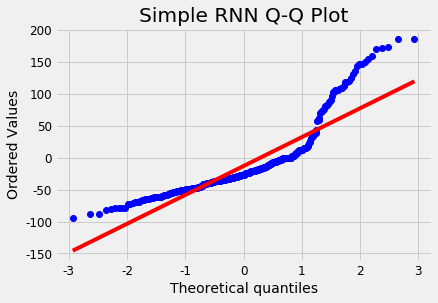

In [233]:
residuals = [y_val_single[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_single - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Q-Q Plot")

#### Validation

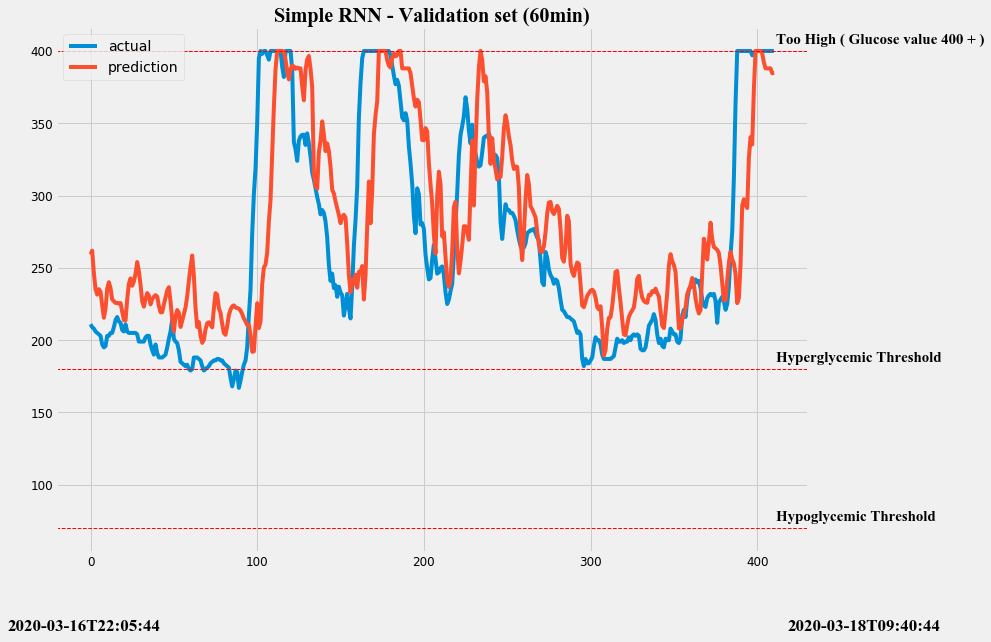

In [234]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

Text(0.5, 1.0, 'Simple RNN 60min Normal Q-Q Plot')

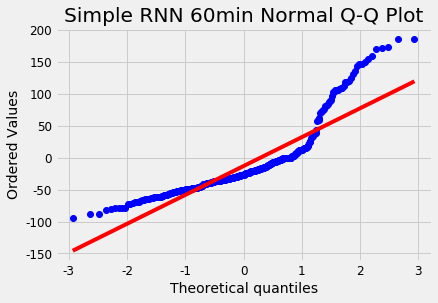

In [235]:
from pandas import DataFrame
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import probplot

#residuals=DataFrame(residuals)

residuals = [y_val_single[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_single - predict_result.reshape(-1)

#residuals

probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN 60min Normal Q-Q Plot")

In [236]:
# 트레이닝셋 rmse 구하는 부분 
predict_result = model.predict(x_train_single,verbose=0)
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400            
print(' Training set / Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_train_single,predict_result))
train_rnn_60=RMSE(y_train_single,predict_result)

 Training set / Vanila RNN (Simple RNN) - RMSE (15min) :  45.87488


#### Train

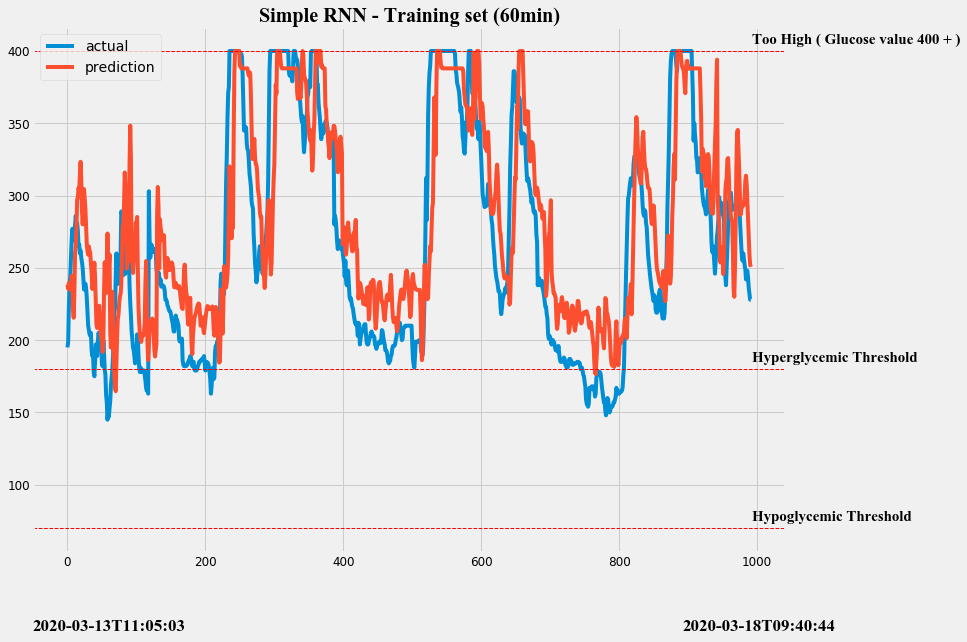

In [237]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Training set (60min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### LSTM - 60분

In [238]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [239]:
model = Sequential()
model.add(LSTM(50,activation='relu',input_shape=x_train_single.shape[-2:]))
model.add(Dense(1))


model.compile(optimizer='adam',loss='mse')

model.fit(x_train_single,y_train_single,epochs=200,verbose=0)

K.clear_session()

In [240]:
predict_result = model.predict(x_val_single,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

#predict_result

print(' LSTM - RMSE (60min) : ',RMSE(y_val_single,predict_result))
val_lstm_60=RMSE(y_val_single,predict_result)

 LSTM - RMSE (60min) :  46.68845


#### 잔차

Text(0.5, 1.0, 'LSTM Q-Q Plot')

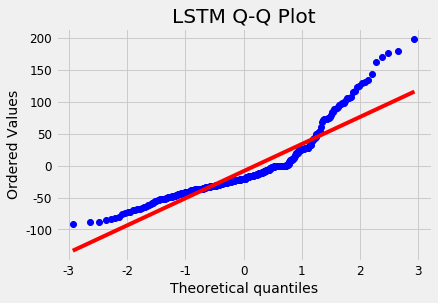

In [241]:
residuals = [y_val_single[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_single - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("LSTM Q-Q Plot")

#### Validation

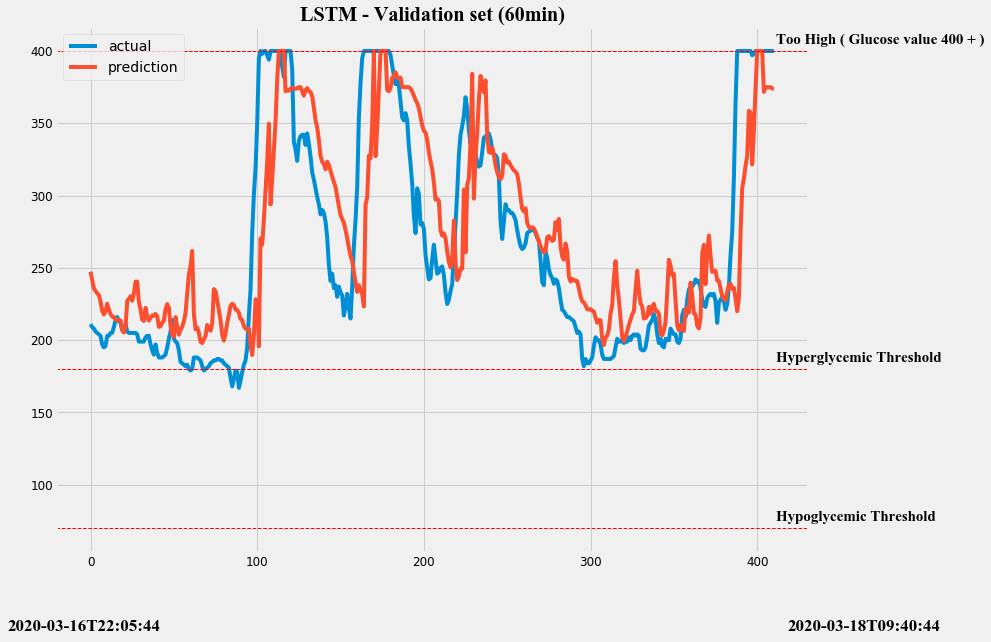

In [242]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [243]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_single,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' LSTM - RMSE (60min) Training set : ',RMSE(y_train_single,predict_result))
train_lstm_60 =RMSE(y_train_single,predict_result)

 LSTM - RMSE (60min) Training set :  43.167065


#### Train

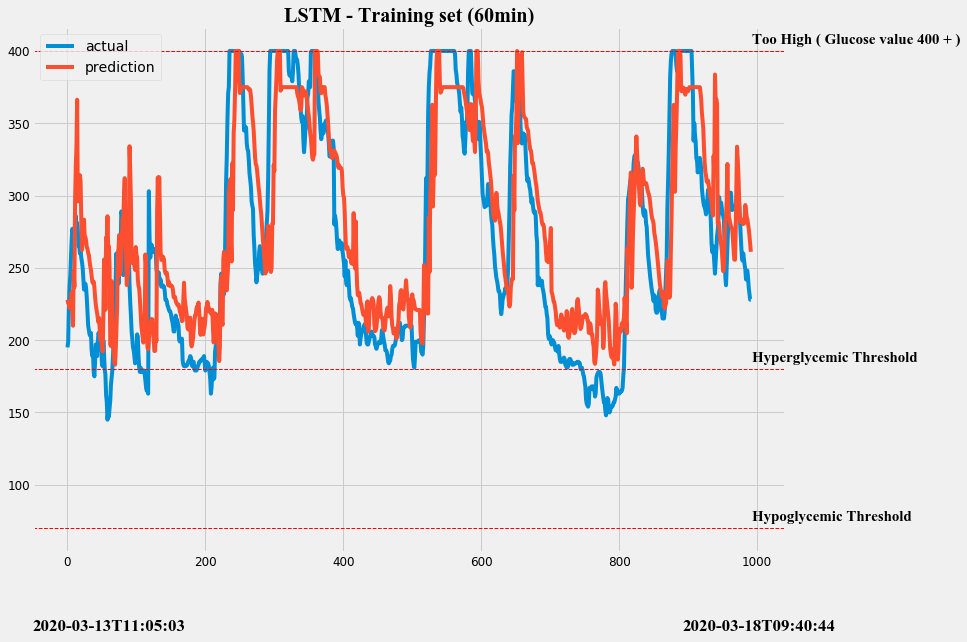

In [244]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Training set (60min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend()
plt.show()

### Stacked LSTM - 60분

In [245]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [246]:
model = Sequential()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=x_train_single.shape[-2:]))
model.add(LSTM(50,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [247]:
model.fit(x_train_single,y_train_single,epochs=200,verbose=0)

K.clear_session()

In [248]:
predict_result = model.predict(x_val_single,verbose=0)


for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

print(' Stacked LSTM - RMSE(15min) : ',RMSE(y_val_single,predict_result))
val_stacklstm_60 =RMSE(y_val_single,predict_result)

 Stacked LSTM - RMSE(15min) :  43.404835


#### 잔차

Text(0.5, 1.0, 'Stacked LSTM Q-Q Plot')

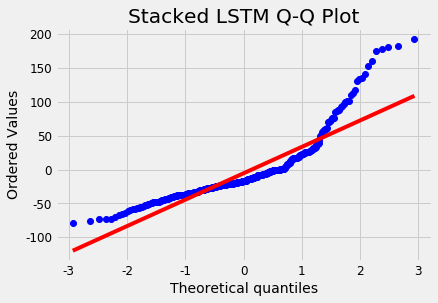

In [249]:
residuals = [y_val_single[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_single - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Stacked LSTM Q-Q Plot")

#### Validation

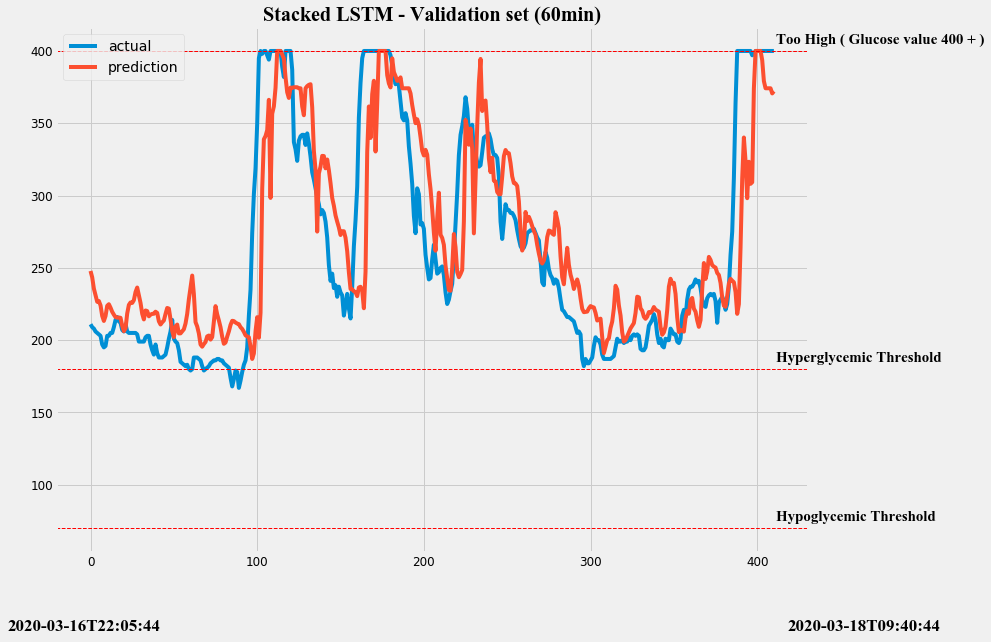

In [250]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [251]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_single,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / STACKED LSTM - RMSE (60min) Training set : ',RMSE(y_train_single,predict_result))
train_stacklstm_60 = RMSE(y_train_single,predict_result)

 Training set / STACKED LSTM - RMSE (60min) Training set :  40.791252


#### Train

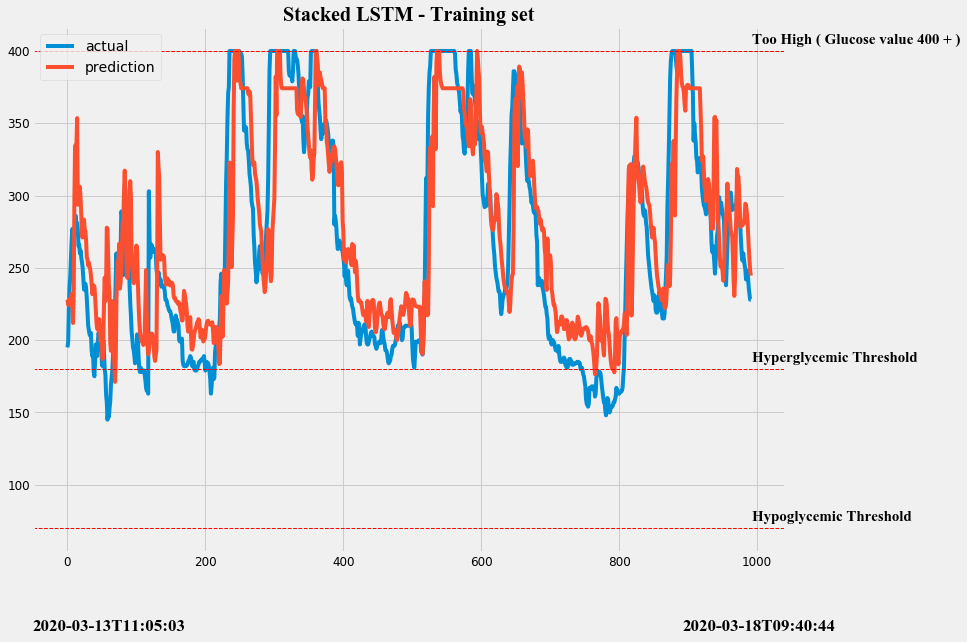

In [252]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### Bidirectional LSTM - 60분

In [253]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [254]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(50,activation='relu'),input_shape=x_train_single.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [255]:
model.fit(x_train_single,y_train_single,epochs=200,verbose=0)

K.clear_session()

In [256]:
predict_result = model.predict(x_val_single,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

print('Bidirectional LSTM - RMSE : ',RMSE(y_val_single,predict_result))
val_bilstm_60 = RMSE(y_val_single,predict_result)

Bidirectional LSTM - RMSE :  46.349274


#### Validation

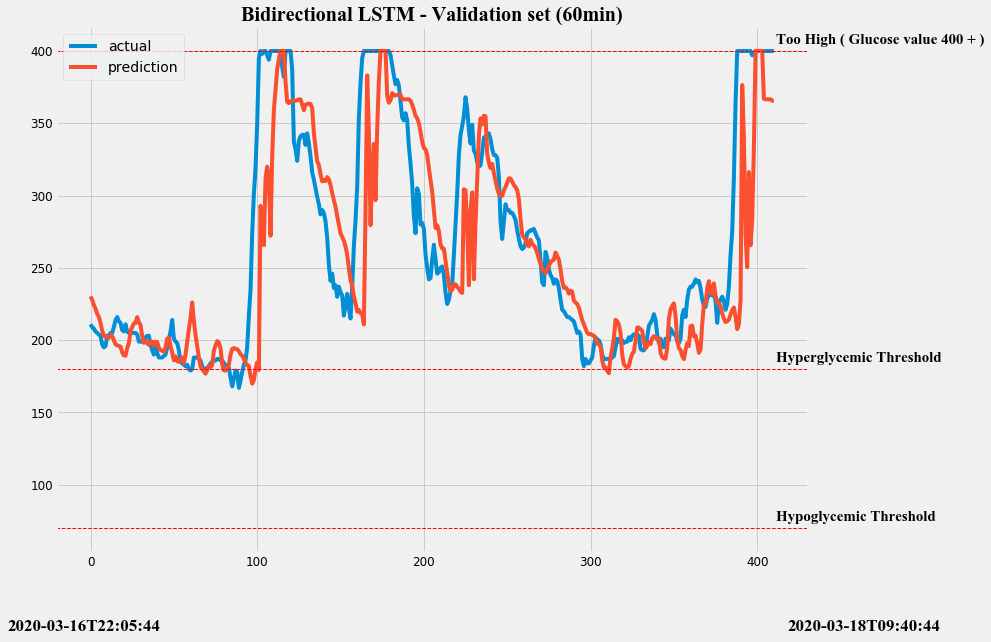

In [257]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

#### 잔차

Text(0.5, 1.0, 'Bidirectional LSTM Q-Q Plot')

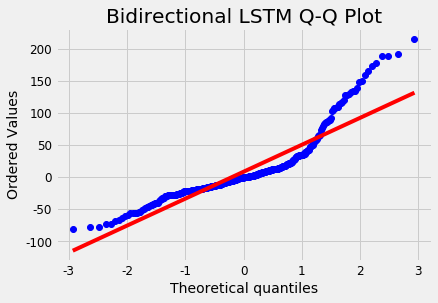

In [258]:
residuals = [y_val_single[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_single - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Bidirectional LSTM Q-Q Plot")

In [259]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_single,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / Bidirectional LSTM - RMSE (60min) Training set : ',RMSE(y_train_single,predict_result))
train_bilstm_60 = RMSE(y_train_single,predict_result)

 Training set / Bidirectional LSTM - RMSE (60min) Training set :  40.949516


#### Train

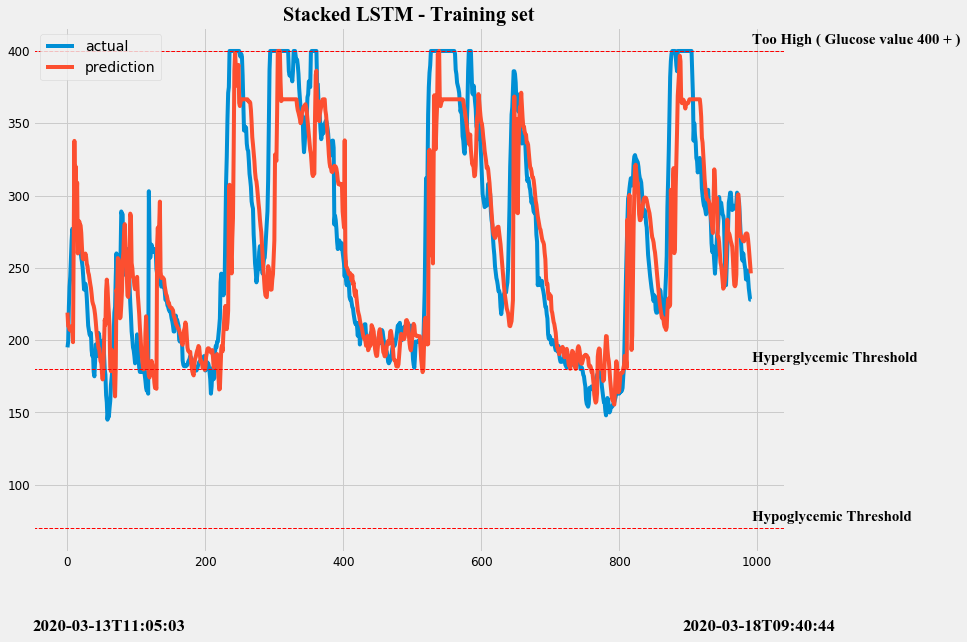

In [260]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GRU - 60분

In [261]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [262]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(50,activation='relu',input_shape=x_train_single.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [263]:
model.summary()

model.fit(x_train_single,y_train_single,epochs=200,verbose=0)

K.clear_session()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                8250      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 8,301
Trainable params: 8,301
Non-trainable params: 0
_________________________________________________________________


In [264]:
predict_result = model.predict(x_val_single,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

#predict_result

#predict_result


print('GRU - RMSE 15min : ',RMSE(y_val_single,predict_result))
val_gru_60 = RMSE(y_val_single,predict_result)
# 상한선 400일 때 RMSE - 38.30 
# 상한선 400 X - 38.63

GRU - RMSE 15min :  51.982136


#### 잔차

Text(0.5, 1.0, 'GRU Q-Q Plot')

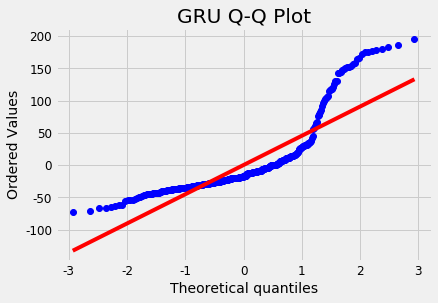

In [265]:
residuals = [y_val_single[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_single - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("GRU Q-Q Plot")

#### Validation

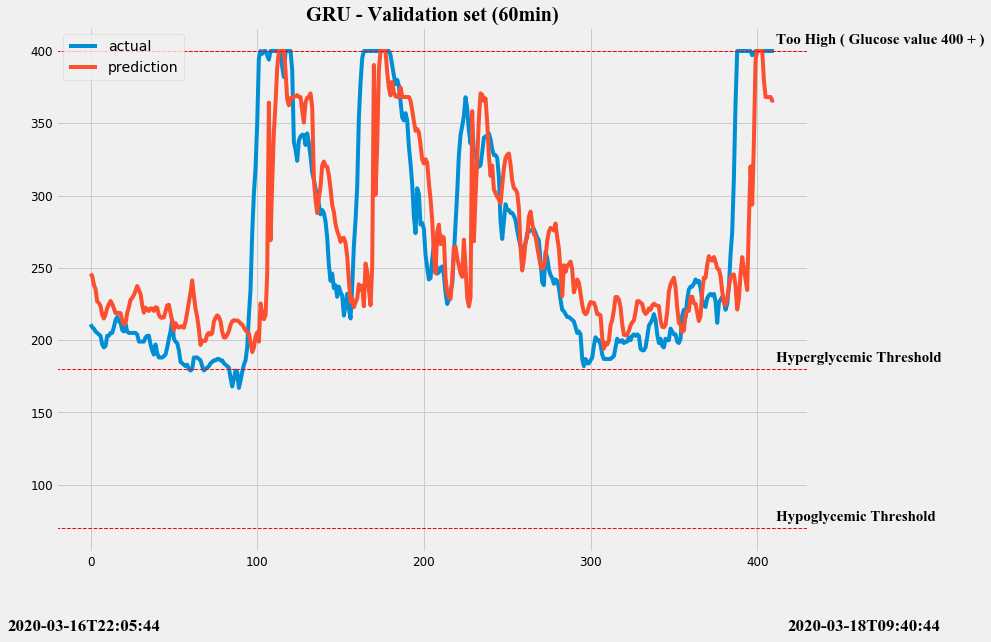

In [266]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [267]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_single,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / GRU - RMSE (60min) Training set : ',RMSE(y_train_single,predict_result))
train_gru_60 =RMSE(y_train_single,predict_result)

 Training set / GRU - RMSE (60min) Training set :  45.284794


#### Train

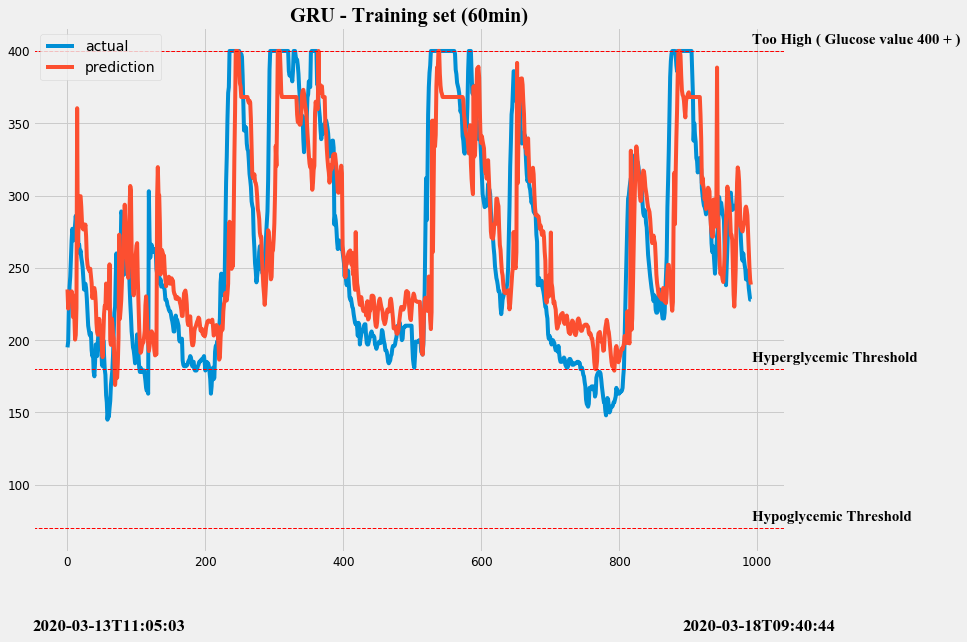

In [268]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Training set (60min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

## 결과

In [269]:
train_15_result = [train_rnn_15,train_lstm_15,train_stacklstm_15,train_bilstm_15,train_gru_15]
val_15_result =[val_rnn_15,val_lstm_15,val_stacklstm_15,val_bilstm_15,val_gru_15]
train_30_result = [train_rnn_30,train_lstm_30,train_stacklstm_30,train_bilstm_30,train_gru_30]
val_30_result =[val_rnn_30,val_lstm_30,val_stacklstm_30,val_bilstm_30,val_gru_30]
train_60_result = [train_rnn_60,train_lstm_60,train_stacklstm_60,train_bilstm_60,train_gru_60]
val_60_result =[val_rnn_60,val_lstm_60,val_stacklstm_60,val_bilstm_60,val_gru_60]


In [270]:
val_rnn_result = [val_rnn_15,val_rnn_30,val_rnn_60]
val_lstm_result = [val_lstm_15,val_lstm_30,val_lstm_60]
val_stacklstm_result = [val_stacklstm_15,val_stacklstm_30,val_stacklstm_60]
val_bilstm_result = [val_bilstm_15,val_bilstm_30,val_bilstm_60]
val_gru_result = [val_gru_15,val_gru_30,val_gru_60]

In [271]:
train_rnn_result = [train_rnn_15,train_rnn_30,train_rnn_60]
train_lstm_result = [train_lstm_15,train_lstm_30,train_lstm_60]
train_stacklstm_result = [train_stacklstm_15,train_stacklstm_30,train_stacklstm_60]
train_bilstm_result = [train_bilstm_15,train_bilstm_30,train_bilstm_60]
train_gru_result = [train_gru_15,train_gru_30,train_gru_60]

In [272]:
train_result_list =[train_rnn_result,train_lstm_result,train_stacklstm_result,train_bilstm_result,train_gru_result]

In [273]:
val_result_list =[val_rnn_result,val_lstm_result,val_stacklstm_result,val_bilstm_result,val_gru_result]

In [274]:
val_result_list

[[19.742668, 33.583378, 51.671482],
 [20.086256, 28.508337, 46.68845],
 [17.331167, 25.48538, 43.404835],
 [19.469698, 25.802187, 46.349274],
 [18.595892, 31.233986, 51.982136]]

In [275]:
val_df = pd.DataFrame(index=['RNN','LSTM','Stacked LSTM','Bidirectional LSTM','GRU'], 
                      columns =['15 MIN','30 MIN','60 MIN'],data=val_result_list)
val_df

15 MIN     30 MIN     60 MIN
RNN                 19.742668  33.583378  51.671482
LSTM                20.086256  28.508337  46.688450
Stacked LSTM        17.331167  25.485380  43.404835
Bidirectional LSTM  19.469698  25.802187  46.349274
GRU                 18.595892  31.233986  51.982136

In [276]:
train_df = pd.DataFrame(index=['RNN','LSTM','Stacked LSTM','Bidirectional LSTM','GRU'], 
                      columns =['15 MIN','30 MIN','60 MIN'],data=train_result_list)
train_df

15 MIN     30 MIN     60 MIN
RNN                 17.730930  28.648260  45.874882
LSTM                19.345827  26.845943  43.167065
Stacked LSTM        16.440697  25.544704  40.791252
Bidirectional LSTM  18.617098  26.487843  40.949516
GRU                 17.459606  28.369259  45.284794

## CNN LSTM